# Mean-state differences

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
import itertools

from tqdm.notebook import tqdm

In [3]:
import cartopy.crs as ccrs
import dask.array as da
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
from adjustText import adjust_text

In [5]:
import iris.plot as iplt
from iris.analysis.maths import apply_ufunc

In [6]:
import iris.quickplot as qplt
from ipywidgets import interact

In [7]:
# My packages and local scripts
import aeolus

print(aeolus.__version__)
from aeolus.calc import (
    abs_coord_mean,
    bond_albedo,
    integrate,
    meridional_mean,
    region_mean_diff,
    spatial,
    spatial_mean,
    time_mean,
    vertical_mean,
    water_path,
    zonal_mean,
)
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import get_cube_rel_days
from aeolus.core import AtmoSim
from aeolus.io import load_data, save_cubelist
from aeolus.meta import const_from_attrs, preserve_shape, update_metadata
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    label_global_map_gridlines,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.subset import DimConstr, extract_last_n_days, l_range_constr

0.4.13+17.gcccf3fa


In [8]:
from pouch.clim_diag import (
    bv_freq_sq,
    calc_derived_cubes,
    d_dphi,
    hgt_cnstr_0_1km,
    latent_heating_rate,
    latitude_of_max_zonal_wind,
    longitude_of_wave_crest,
    mean_dry_lapse_rate,
    ratio_of_dn_to_eq_pole_temp_diff,
    upper_atm_vap_mean,
    wind_rot_div,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_CART,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    draw_scalar_cube,
    draw_vector_cubes,
    figsave,
    linspace_pm1,
    make_map_figure,
    use_style,
)

In [9]:
import mypaths
from commons import (
    DAYSIDE,
    GLM_MODEL_TIMESTEP,
    GLM_SUITE_ID,
    NIGHTSIDE,
    OPT_LABELS,
    SIM_LABELS,
    SUITE_LABELS,
    as_lon,
    cold_traps,
    eq_lat,
    free_troposphere,
    mid_lat,
    midlatitudes,
    ss_lon,
    troposphere,
)

In [10]:
use_style()

# plt.style.use("dark_background")

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

### Load all sensitivity experiments

In [11]:
img_prefix = f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days_6000"
plotdir = mypaths.plotdir / img_prefix

In [12]:
# Load processed data
runs = {}
runs_p = {}
for suite_label, suite_prop in tqdm(SUITE_LABELS.items()):
    top_label = f"{GLM_SUITE_ID}_{suite_label}"
    planet = suite_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    procdir = mypaths.sadir / top_label
    for opt_label in tqdm(OPT_LABELS.keys(), leave=False):
        if opt_label != "base":
            ...
            # continue
        sim_label = f"{suite_label}_{opt_label}"
        if sim_label not in SIM_LABELS.keys():
            continue
        if opt_label == "base":
            time_prof = "mean_days6000_9950"
        elif sim_label == "grcs_sens-noradcld":
            time_prof = "mean_days2000_2200"
        else:
            time_prof = "mean_days2000_2950"
        cl = load_data(
            files=procdir / f"{top_label}_{opt_label}_{time_prof}.nc",
        )
        add_planet_conf_to_cubes(cl, const)
        # Derive additional fields
        calc_derived_cubes(cl, const=const, model=um)
        # Use the cube list to initialise an AtmoSim object
        runs[sim_label] = AtmoSim(
            cl,
            name=sim_label,
            planet=planet,
            const_dir=mypaths.constdir,
            timestep=cl[0].attributes["timestep"],
            model=um,
            vert_coord="z",
        )
        # Cubes on pressure levels
        cl_p = load_data(procdir / f"{top_label}_{opt_label}_{time_prof}_plev.nc")
        runs_p[sim_label] = AtmoSim(
            cl_p,
            name=sim_label,
            planet=planet,
            const_dir=mypaths.constdir,
            timestep=cl[0].attributes["timestep"],
            model=um,
            vert_coord="p",
        )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

### Jet speed and wave-jet resonance

In [108]:
from aeolus.coord import broadcast_to_shape
from iris.util import reverse


def vertical_mean_p(cube, model=um):
    """Mass-weighted vertical mean in pressure coordinates."""
    vmean = integrate(reverse(cube, model.pres), model.pres)
    vmean /= cube.coord(model.pres)[np.argmax(cube.coord(model.pres).points)]
    return vmean

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__u_eq_lat_rossby_wave_speed__min_max.png


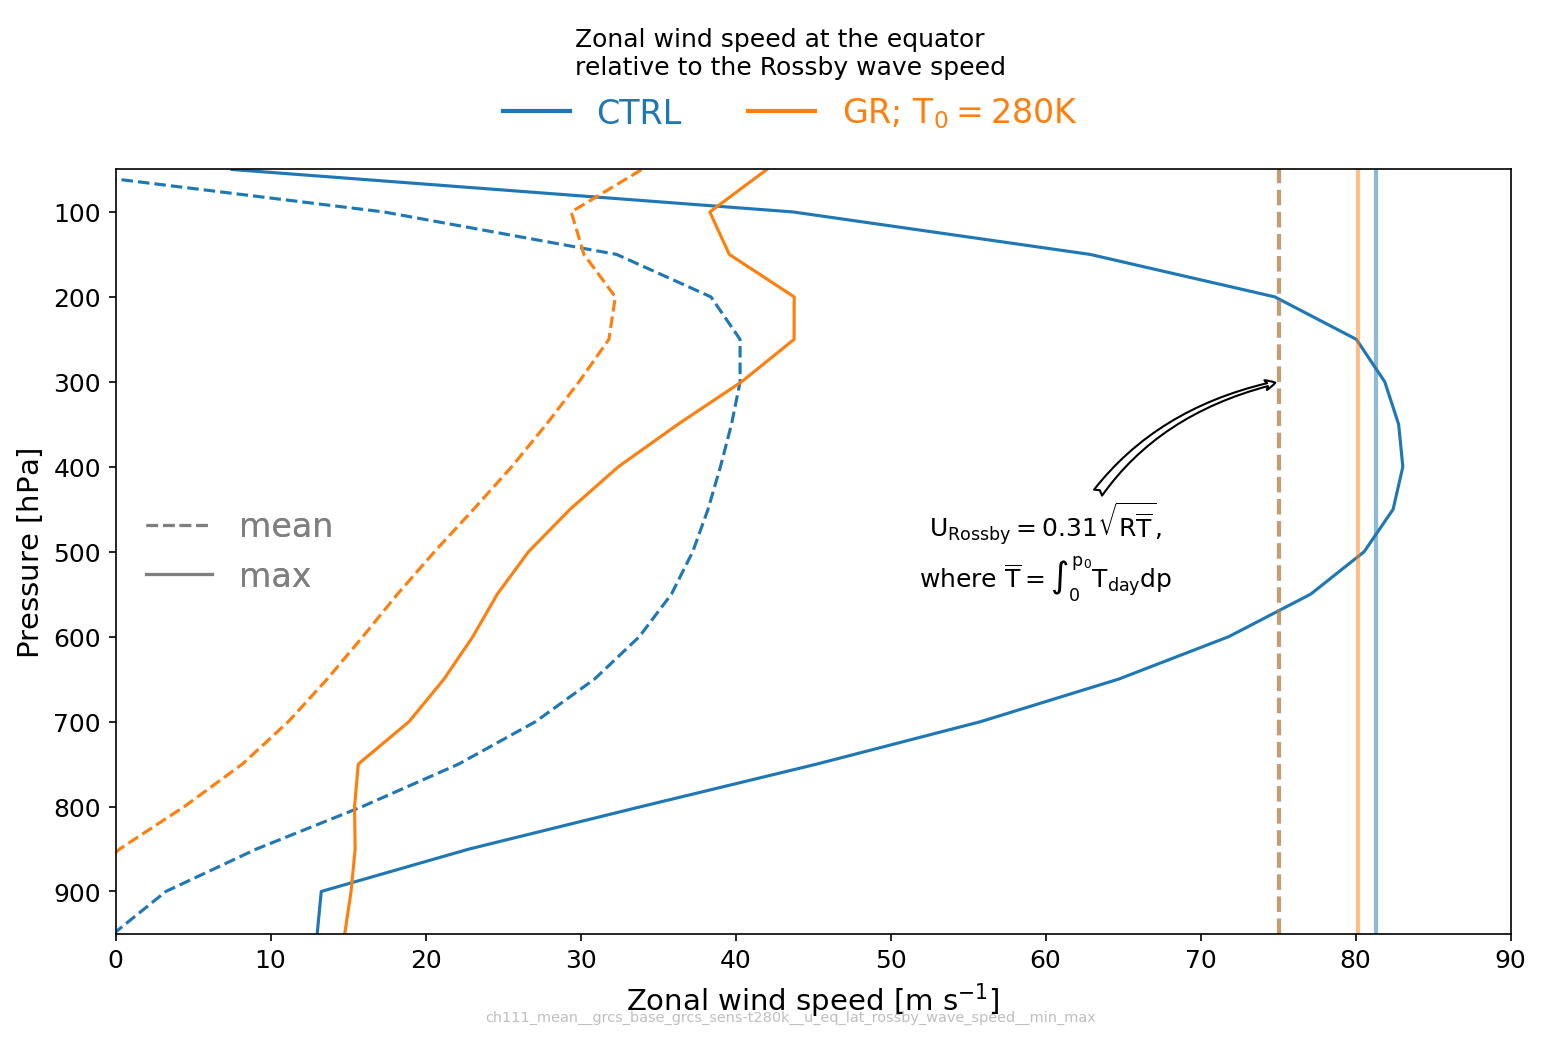

In [169]:
imgname = (
    f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__u_eq_lat_rossby_wave_speed__min_max"
)

fig, ax = plt.subplots()

for (sim_label, sim_opt) in SIM_LABELS.items():
    temp = time_mean(runs_p[sim_label].temp)
    temp_mean = spatial(vertical_mean_p(temp.extract(DAYSIDE.constraint)), "mean")
    temp_max = spatial(vertical_mean_p(temp.extract(DAYSIDE.constraint)), "max")
    u_rossby_mean = (
        0.31 * (runs_p[sim_label].const.dry_air_gas_constant * temp_min) ** 0.5
    )
    u_rossby_max = (
        0.31 * (runs_p[sim_label].const.dry_air_gas_constant * temp_max) ** 0.5
    )

    u = time_mean(runs_p[sim_label].u.extract(eq_lat))
    u_mean = spatial(u, "mean")
    u_max = spatial(u, "max")
    ax.plot(
        u_mean.data,
        runs_p[sim_label].coord.z.points * 1e-2,
        **sim_opt["kw_plt"],
        linestyle="--",
        label=sim_opt["title"],
    )
    ax.plot(
        u_max.data,
        runs_p[sim_label].coord.z.points * 1e-2,
        **sim_opt["kw_plt"],
        linestyle="-",
        label=sim_opt["title"],
    )
    ax.axvline(u_rossby_mean.data, **sim_opt["kw_plt"], lw=2, alpha=0.5, linestyle="--")
    ax.axvline(u_rossby_max.data, **sim_opt["kw_plt"], lw=2, alpha=0.5, linestyle="-")

ann = ax.annotate(
    "$U_{Rossby}=0.31\sqrt{R\overline{T}}$,\nwhere $\overline{T}=\int_0^{p_0}T_{day}dp$",
    xy=(u_rossby_min.data, 300),
    xycoords="data",
    xytext=(60, 500),
    textcoords="data",
    size=12,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="fancy", connectionstyle="arc3,rad=-0.3", relpos=(0.5, 0.0), fc="w"
    ),
)
ax.set_ylim(950, 50)
ax.set_xlim(0, 90)
ax.set_xlabel("Zonal wind speed [$m$ $s^{-1}$]")
ax.set_ylabel("Pressure [$hPa$]")

add_custom_legend(
    ax,
    {
        "mean": {"linestyle": "--", "color": "tab:grey"},
        "max": {"linestyle": "-", "color": "tab:grey"},
    },
    loc="center left",
    frameon=False,
    ncol=1,
)
add_custom_legend(
    fig,
    {v["title"]: {"linewidth": 2, **v["kw_plt"]} for v in SIM_LABELS.values()},
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    ncol=2,
    title="Zonal wind speed at the equator\nrelative to the Rossby wave speed",
)

figsave(fig, plotdir / imgname)

## Maps and cross-sections of the mean state in base experiments

In [13]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})
P_LEV2 = 500  # hPa
p_lev_constr2 = iris.Constraint(**{um.pres: P_LEV2 * 1e2})

In [14]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points
    RESULTS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))
    RESULTS[sim_label]["sigma_p_lev1"] = (
        P_LEV1 * 1e2 / the_run.const.reference_surface_pressure.data
    )
    RESULTS[sim_label]["sigma_p_lev2"] = (
        P_LEV2 * 1e2 / the_run.const.reference_surface_pressure.data
    )

    ghgt = the_run_p.ghgt.extract(p_lev_constr1) / the_run_p.const.gravity
    RESULTS[sim_label]["ghgt_dev"] = time_mean(ghgt - zonal_mean(ghgt))
    wave_crest_lon = longitude_of_wave_crest(ghgt)
    RESULTS[sim_label]["wave_crest_lon"] = wave_crest_lon
    RESULTS[sim_label]["wave_crest_lon_tm"] = time_mean(wave_crest_lon)
    RESULTS[sim_label]["temp_map"] = time_mean(the_run_p.temp.extract(p_lev_constr2))
    u = the_run_p.u.extract(p_lev_constr1)
    v = the_run_p.v.extract(p_lev_constr1)
    u_map = time_mean(u)
    v_map = time_mean(v)
    RESULTS[sim_label]["u_map"] = u_map
    RESULTS[sim_label]["v_map"] = v_map
    RESULTS[sim_label]["u_eddy_map"] = time_mean(u - zonal_mean(u))
    RESULTS[sim_label]["v_eddy_map"] = time_mean(v - zonal_mean(v))
    RESULTS[sim_label]["u_cross"] = time_mean(zonal_mean(the_run.u))
    RESULTS[sim_label]["temp_cross"] = time_mean(zonal_mean(the_run.temp))

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# Plot style for wind vectors
KW_QUIVER = dict(
    scale_units="inches",
    scale=200,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)
KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

KW_QUIVER_EDDY = dict(
    scale_units="inches",
    scale=100,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

KW_TEMP = dict(
    levels=np.arange(100, 1000, 5),
    cmap=cm.batlow,
    norm=mpl.colors.Normalize(vmin=210, vmax=260),
    extend="both",
)

### Temperature, winds, geopotential height

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__temp_300hpa_winds_ghgt_dev_map_500hpa_u_temp_vcross.png


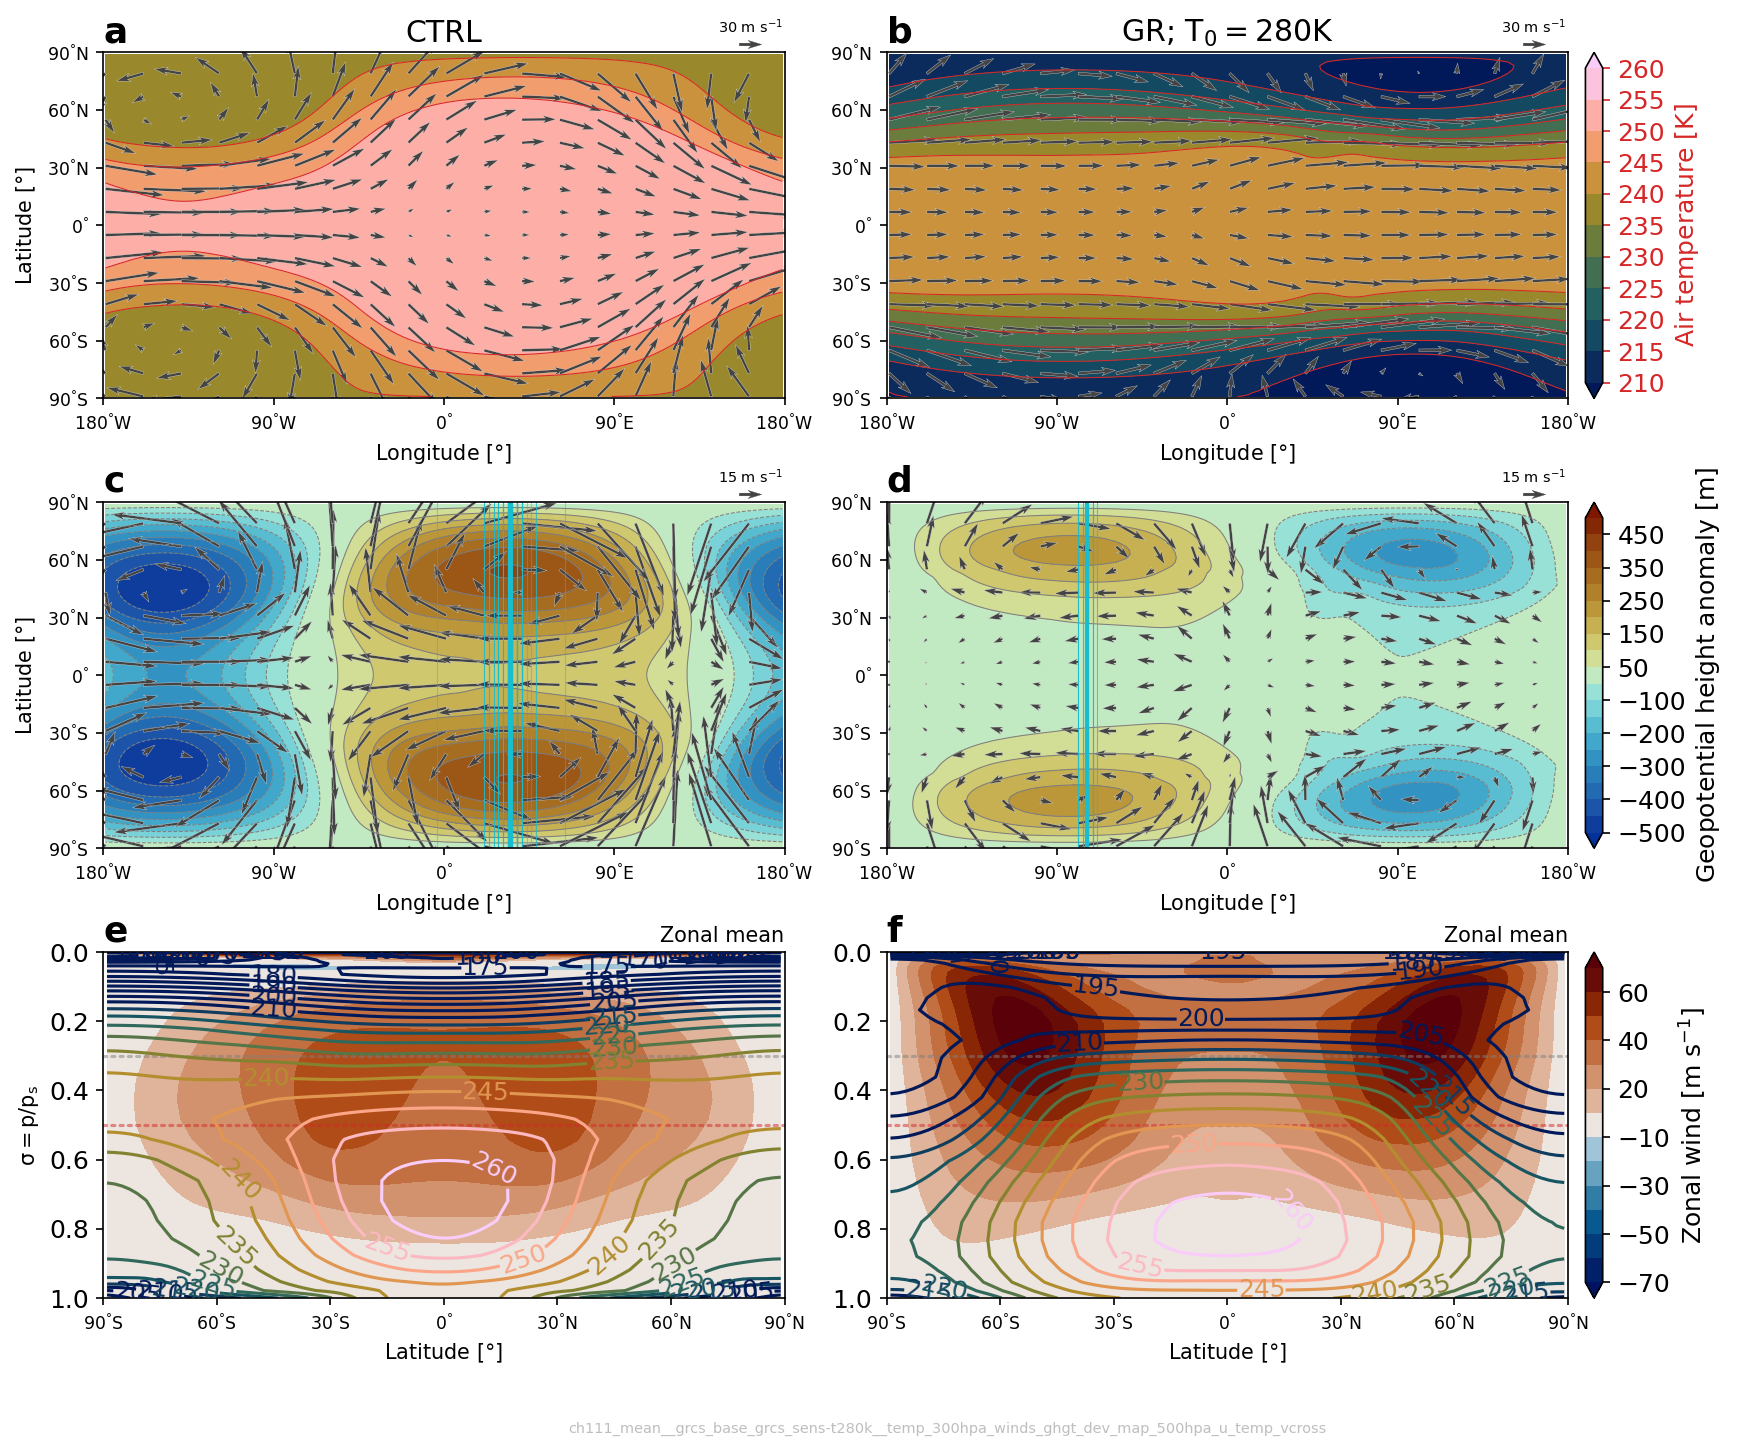

In [16]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__temp_{P_LEV1}hpa_winds_ghgt_dev_map_{P_LEV2}hpa_u_temp_vcross"

ncols = 2
nrows = 3

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 11),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[:2, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")
for ax in axs[-1, :]:
    ax.set_xticks(YLOCS)
    ax.set_xlabel("Latitude [$\degree$]", fontsize="small")
    ax.set_xlim((-90, 90))
    ax.set_xticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
    ax.set_ylim((1, 0))
    ax.set_title("Zonal mean", **KW_AUX_TTL)

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    _p0 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["temp_map"].data,
        **KW_TEMP,
    )
    ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["temp_map"].data,
        colors="tab:red",
        levels=KW_TEMP["levels"],
        linewidths=0.5,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_map"].data[ysl, xsl],
        RESULTS[sim_label]["v_map"].data[ysl, xsl],
        **KW_QUIVER,
    )
    qk_ref_wspd = 30
    ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )

    ax = axcol[1]
    _p1 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["ghgt_dev"].data,
        cmap=cm.roma_r,
        levels=linspace_pm1(10) * 500,
        extend="both",
    )
    ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["ghgt_dev"].data,
        levels=linspace_pm1(10) * 500,
        colors="tab:grey",
        linewidths=0.5,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_eddy_map"].data[ysl, xsl],
        RESULTS[sim_label]["v_eddy_map"].data[ysl, xsl],
        **KW_QUIVER_EDDY,
    )
    qk_ref_wspd = 15
    _qk = ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )
    ax.plot(
        [
            RESULTS[sim_label]["wave_crest_lon"].data,
            RESULTS[sim_label]["wave_crest_lon"].data,
        ],
        [-90, 90],
        color="tab:cyan",
        linewidth=0.5,
        alpha=0.5,
    )
    ax.plot(
        [
            RESULTS[sim_label]["wave_crest_lon_tm"].data,
            RESULTS[sim_label]["wave_crest_lon_tm"].data,
        ],
        [-90, 90],
        color="tab:cyan",
        linewidth=2,
    )

    ax = axcol[2]
    ax.axhline(
        y=RESULTS[sim_label]["sigma_p_lev1"],
        **KW_ZERO_LINE,
    )
    ax.axhline(
        y=P_LEV2 * 1e2 / the_run.const.reference_surface_pressure.data,
        **{**KW_ZERO_LINE, "color": "tab:red"},
    )
    _p2 = ax.contourf(
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["u_cross"].data,
        levels=linspace_pm1(7) * 70,
        cmap=cm.vik,
        extend="both",
    )
    _p3 = ax.contour(
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["temp_cross"].data,
        **KW_TEMP,
    )
    ax.clabel(_p3, fmt="%.0f")

_cbar0 = fig.colorbar(_p0, ax=axs[0, :], **KW_CBAR)
_cbar0.ax.set_ylim(KW_TEMP["norm"].vmin, KW_TEMP["norm"].vmax)
_cbar0.set_ticks(
    np.arange(
        KW_TEMP["norm"].vmin,
        KW_TEMP["norm"].vmax + np.diff(KW_TEMP["levels"])[0],
        np.diff(KW_TEMP["levels"])[0],
    )
)
_cbar0.ax.tick_params(colors="tab:red")
_cbar0.ax.set_ylabel("Air temperature [$K$]", color="tab:red", **KW_CBAR_TTL)
_cbar1 = fig.colorbar(_p1, ax=axs[1, :], **KW_CBAR)
_cbar1.ax.set_ylabel("Geopotential height anomaly [$m$]", **KW_CBAR_TTL)
_cbar2 = fig.colorbar(_p2, ax=axs[2, :], **KW_CBAR)
_cbar2.ax.set_ylabel("Zonal wind [$m$ $s^{-1}$]", **KW_CBAR_TTL)

figsave(fig, plotdir / imgname)

### Helmholtz decomposition

In [14]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})

In [15]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points
    RESULTS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))

    u = time_mean(runs_p[sim_label].u.extract(p_lev_constr1))
    v = time_mean(runs_p[sim_label].v.extract(p_lev_constr1))
    w = time_mean(runs_p[sim_label].w.extract(p_lev_constr1))

    RESULTS[sim_label].update(wind_rot_div(u, v))
    RESULTS[sim_label]["w"] = w
    del u, v, w

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
KW_W = dict(
    cmap=cm.vik,
    levels=linspace_pm1(10) * 5,
    extend="both",
)

KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

KW_QUIVER = dict(
    scale_units="inches",
    scale=200,
    # facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

In [13]:
WIND_CMPNT_META = {
    "total": {"title": "Total", "qk_ref_wspd": 60, "kw_plt": dict(color="#222222")},
    "div": {"title": "Divergent", "qk_ref_wspd": 10, "kw_plt": dict(color="C0")},
    "rot_zm": {"title": "Jet", "qk_ref_wspd": 60, "kw_plt": dict(color="C1")},
    "rot_eddy": {"title": "Eddy", "qk_ref_wspd": 30, "kw_plt": dict(color="C2")},
}

In [21]:
winds_to_plot = ["rot_zm", "rot_eddy", "div"]

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__rotdiv_300hpa.png


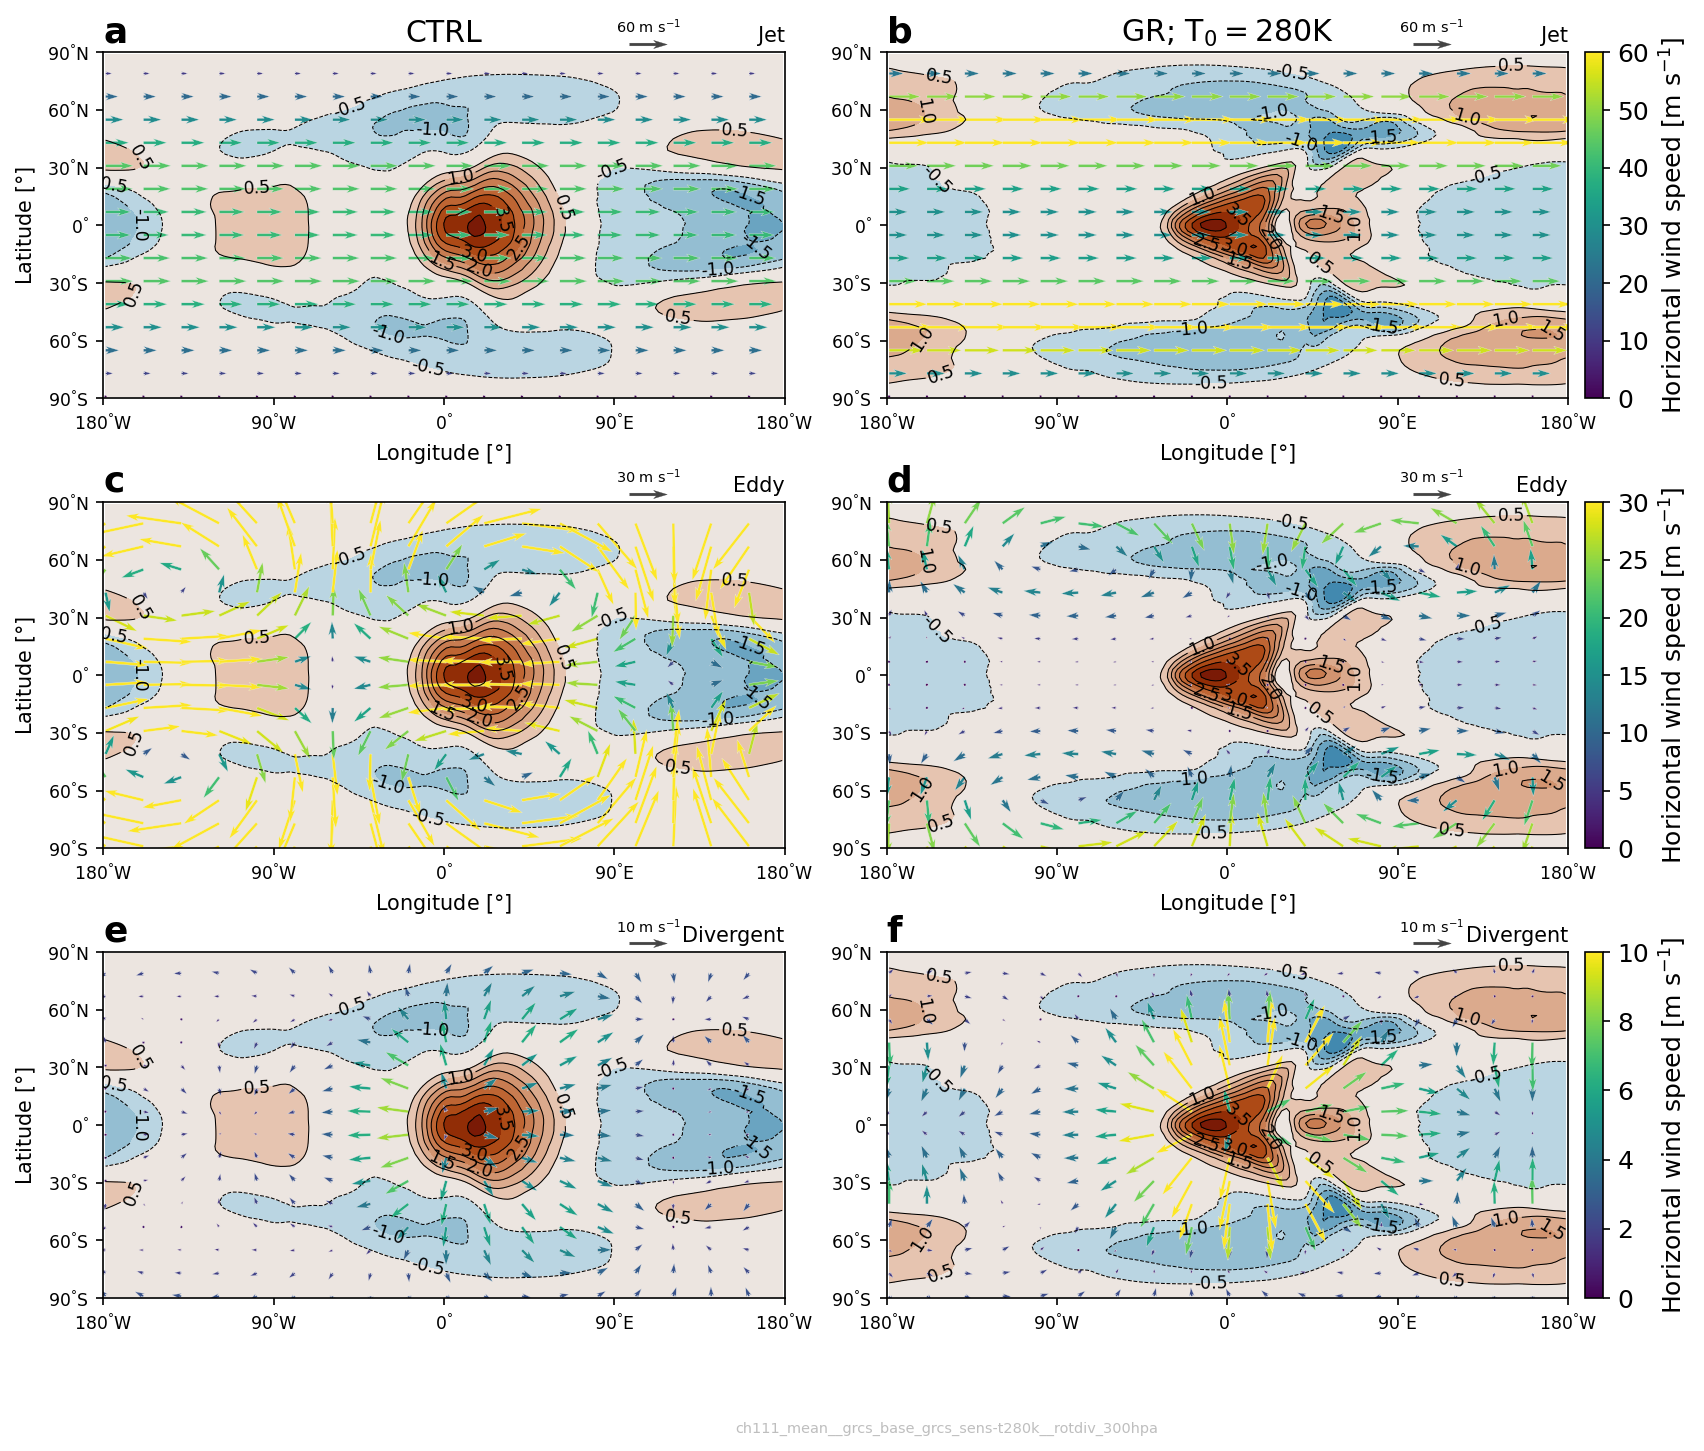

In [22]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__rotdiv_{P_LEV1}hpa"

ncols = 2
nrows = len(winds_to_plot)

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 11),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[:, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")


for wind_key, axrow in zip(winds_to_plot, axs):
    wind_meta = WIND_CMPNT_META[wind_key]
    for (sim_label, sim_prop), ax in zip(SIM_LABELS.items(), axrow):
        ax.set_title(wind_meta["title"], **KW_AUX_TTL)
        if ax.get_subplotspec().is_first_row():
            ax.set_title(sim_prop["title"], **KW_MAIN_TTL)

        _u = RESULTS[sim_label][f"u_{wind_key}"]
        _v = RESULTS[sim_label][f"v_{wind_key}"]
        _p0 = ax.contourf(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            RESULTS[sim_label]["w"].data * 1e2,
            **KW_W,
        )
        _p00 = ax.contour(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["lats"],
            RESULTS[sim_label]["w"].data * 1e2,
            levels=KW_W["levels"],
            colors="k",
            linewidths=0.5,
        )
        _clbl = ax.clabel(_p00, fmt="%.1f", fontsize="x-small")
        qk_ref_wspd = wind_meta["qk_ref_wspd"]
        _kw_quiv = {**KW_QUIVER, **{"scale": qk_ref_wspd * 4}}
        _q = ax.quiver(
            RESULTS[sim_label]["lons"][xsl],
            RESULTS[sim_label]["lats"][ysl],
            _u.data[ysl, xsl],
            _v.data[ysl, xsl],
            (_u.data[ysl, xsl] ** 2 + _v.data[ysl, xsl] ** 2) ** 0.5,
            norm=plt.Normalize(0, qk_ref_wspd),
            cmap="viridis",
            **_kw_quiv,
        )
        ax.quiverkey(
            _q,
            *(0.8, 1.025),
            qk_ref_wspd,
            fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
            **KW_QUIVERKEY,
        )
    _cbar0 = fig.colorbar(_q, ax=axrow, **KW_CBAR)
    _cbar0.ax.set_ylabel("Horizontal wind speed [$m$ $s^{-1}$]", **KW_CBAR_TTL)
# _cbar1 = fig.colorbar(_p0, ax=axs, orientation="horizontal", pad=0.125, shrink=0.5)
# _cbar1.ax.set_xlabel(r"Vertical wind speed [$\times 10^{-2}$ $m$ $s^{-1}$]", **KW_CBAR_TTL)

figsave(fig, plotdir / imgname)

### MSE flux divergence by wind components

$s = c_p T + gz + L q$

$\langle\nabla \cdot s \mathbf{u}\rangle+F_{\mathrm{ISR}}-F_{\mathrm{OLR}}=0$

Why does divergent dominate?
$$
\nabla_{p} \cdot s \boldsymbol{u}=s \nabla_{p} \cdot \boldsymbol{u}+\boldsymbol{u} \cdot \nabla_{p} s
$$
Slowly rotating terrestrial planet:
WTG regime, which means
$$
\nabla_{p} s \approx 0
$$
so that
$$
\nabla_{p} \cdot s \boldsymbol{u} \approx s \nabla_{p} \cdot \boldsymbol{u}=s \nabla_{p} \cdot \boldsymbol{u}_{\mathrm{D}}
$$

[Hammond & Lewis 2021]

In [14]:
from pouch.clim_diag import moist_static_energy

In [15]:
from aeolus.calc import div_h, integrate


@const_from_attrs()
def flux_div_h_int_v(
    flux_x,
    flux_y,
    weights,
    constr=None,
    const=None,
    truncation=None,
    opt="finite_diff",
    model=um,
):
    """Vertical integral of the horizontal flux divergence."""
    from cf_units import Unit

    flux_x = flux_x.extract(constr) * weights.extract(constr)
    flux_y = flux_y.extract(constr) * weights.extract(constr)
    if opt == "spectral":
        from windspharm.iris import VectorWind

        vec = VectorWind(flux_x, flux_y, rsphere=const.radius.data)
        hdiv = vec.divergence(truncation=truncation)
        hdiv.units = flux_y.units / Unit("m")
    elif opt == "finite_diff":
        hdiv = div_h(flux_x, flux_y, model=model)
        hdiv.convert_units(flux_y.units / Unit("m"))
    # out = integrate(out * weights, model.z)
    out = integrate(hdiv, model.z)
    out = meridional_mean(out)
    return out

In [16]:
_constr = l_range_constr(0, 90) & iris.Constraint(**{um.y: lambda x: abs(x.point) < 95})

In [17]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points

    u = time_mean(the_run.u)
    v = time_mean(the_run.v)
    rho = time_mean(the_run.dens)
    RESULTS[sim_label]["toa_net"] = meridional_mean(time_mean(the_run.toa_net_energy))

    wind_cmpnts = wind_rot_div(u, v)
    mse_cmpnts = {
        k: time_mean(val)
        for k, val in moist_static_energy(the_run._cubes).items()
    }

    # mse_hdiv_cmpnts = {}
    for mse_key, cmpnt in tqdm(mse_cmpnts.items(), leave=False):
        RESULTS[sim_label][mse_key] = {}
        for wind_key, _ in tqdm(WIND_CMPNT_META.items(), leave=False):
            u_cmpnt, v_cmpnt = (
                wind_cmpnts[f"u_{wind_key}"],
                wind_cmpnts[f"v_{wind_key}"],
            )
            f_x = u_cmpnt * cmpnt
            f_y = v_cmpnt * cmpnt
            RESULTS[sim_label][mse_key][wind_key] = flux_div_h_int_v(
                f_x,
                f_y,
                rho,
                _constr,
                const=runs[sim_label].const,
                truncation=None,  # opt="spectral"
            )
            RESULTS[sim_label][mse_key][wind_key] *= -1  # convergence
            RESULTS[sim_label][mse_key][wind_key].convert_units("W m^-2")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__tmm_rot_div_flux_mse.png


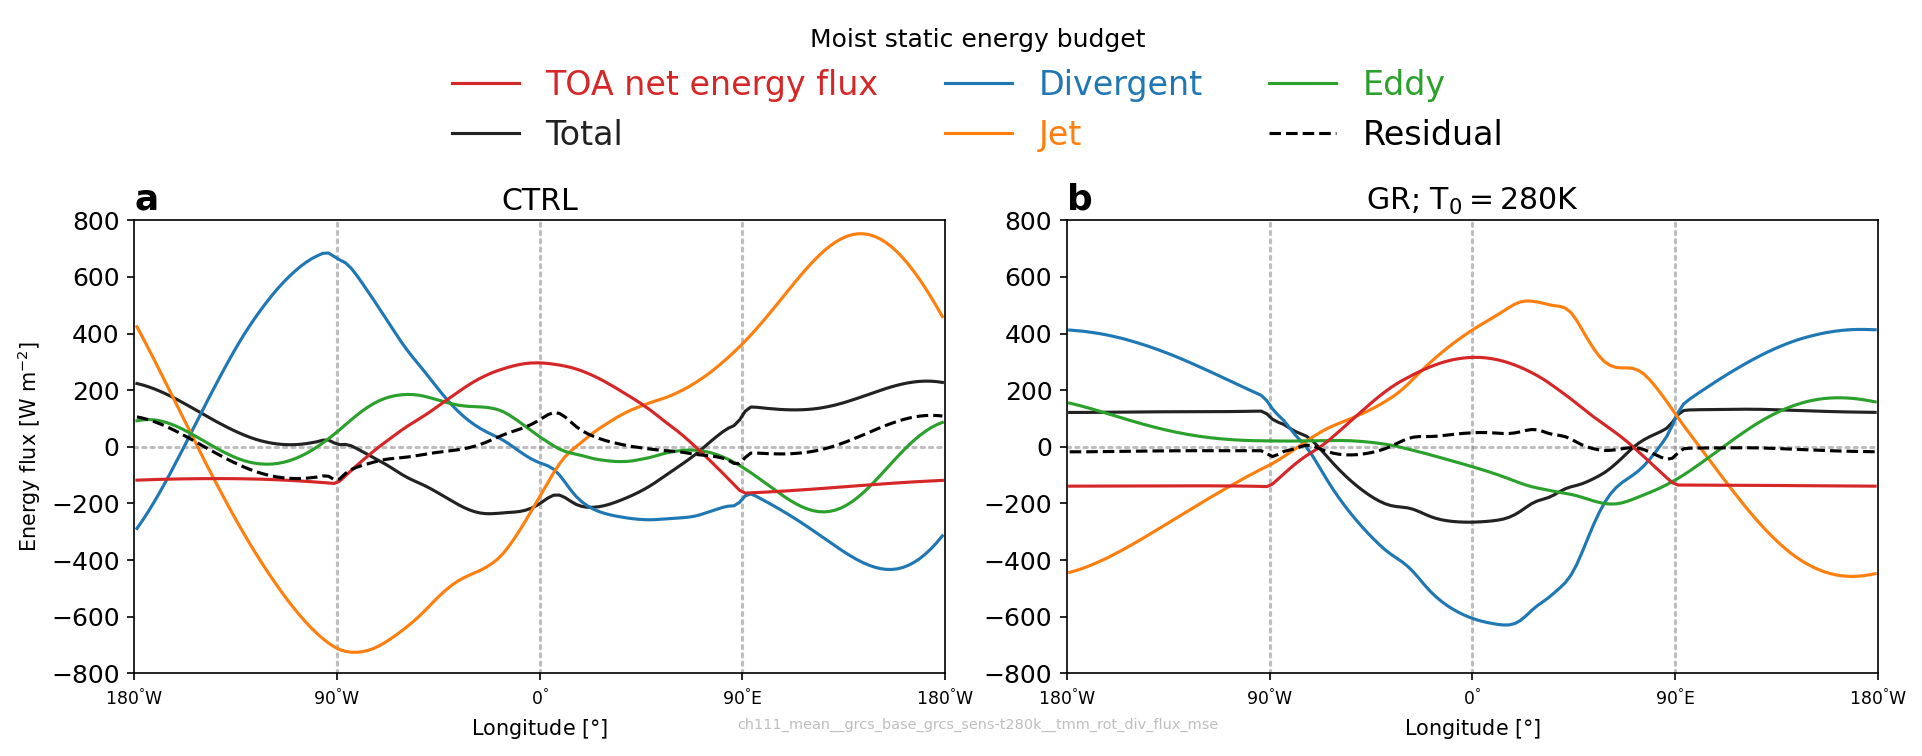

In [27]:
mse_key = "mse"

imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__tmm_rot_div_flux_{mse_key}"

ncols = len(SIM_LABELS)
nrows = 1

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 4),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
    squeeze=False,
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.axhline(0, **KW_ZERO_LINE)
    for _lon in [-90, 0, 90]:
        ax.axvline(_lon, **KW_ZERO_LINE)
    ax.set_ylim(-800, 800)
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.is_first_col():
        ax.set_ylabel("Energy flux [$W$ $m^{-2}$]", fontsize="small")
    if ax.is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    for wind_key, wind_meta in WIND_CMPNT_META.items():
        ax.plot(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label][mse_key][wind_key].data,
            **wind_meta["kw_plt"],
        )
    ax.plot(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["toa_net"].data,
        color="C3",
    )
    if mse_key == "mse":
        ax.plot(
            RESULTS[sim_label]["lons"],
            RESULTS[sim_label]["toa_net"].data
            + RESULTS[sim_label][mse_key]["total"].data,
            linestyle="--",
            color="k",
        )
add_custom_legend(
    fig,
    {
        **{"TOA net energy flux": {"color": "C3"}},
        **{v["title"]: v["kw_plt"] for v in WIND_CMPNT_META.values()},
        **{"Residual": {"linestyle": "--", "color": "k"}},
    },
    title="Moist static energy budget",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    frameon=False,
    ncol=3,
)

figsave(fig, plotdir / imgname)

### Diabatic heating

In [23]:
mid_troposphere = l_range_constr(1.5, 13)
tex_units = "$K$ $day^{-1}$"

In [24]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points
    RESULTS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))

    dt_diab = sum(
        [the_run.dt_sw, the_run.dt_lw, the_run.dt_bl, the_run.dt_lsppn, the_run.dt_cv]
    )
    dt_nonrad = sum([the_run.dt_bl, the_run.dt_lsppn, the_run.dt_cv])
    RESULTS[sim_label]["dt_diab_eq_lat"] = time_mean(dt_diab.extract(eq_lat))
    RESULTS[sim_label]["dt_diab_day_zm"] = time_mean(
        zonal_mean(dt_diab.extract(DAYSIDE.constraint))
    )
    RESULTS[sim_label]["dt_diab_mid_trop"] = time_mean(
        vertical_mean(
            dt_diab.extract(mid_troposphere),
            weight_by=the_run.dens.extract(mid_troposphere),
        )
    )
    RESULTS[sim_label]["dt_nonrad_eq_lat"] = time_mean(dt_nonrad.extract(eq_lat))
    RESULTS[sim_label]["dt_nonrad_day_zm"] = time_mean(
        zonal_mean(dt_nonrad.extract(DAYSIDE.constraint))
    )
    RESULTS[sim_label]["dt_nonrad_mid_trop"] = time_mean(
        vertical_mean(
            dt_nonrad.extract(mid_troposphere),
            weight_by=the_run.dens.extract(mid_troposphere),
        )
    )
    for vrbl_key in RESULTS[sim_label].keys():
        if vrbl_key.startswith("dt_"):
            RESULTS[sim_label][vrbl_key].convert_units(tex2cf_units(tex_units))

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
KW_HEATING = dict(cmap=cm.vik, levels=linspace_pm1(10) * 10, extend="both")
KW_CBAR = dict(pad=0.02, shrink=0.75)
KW_CBAR_TTL = dict(size="medium")

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__dt_diab_dt_nonrad__mid_trop_eq_lat_day_zm.png


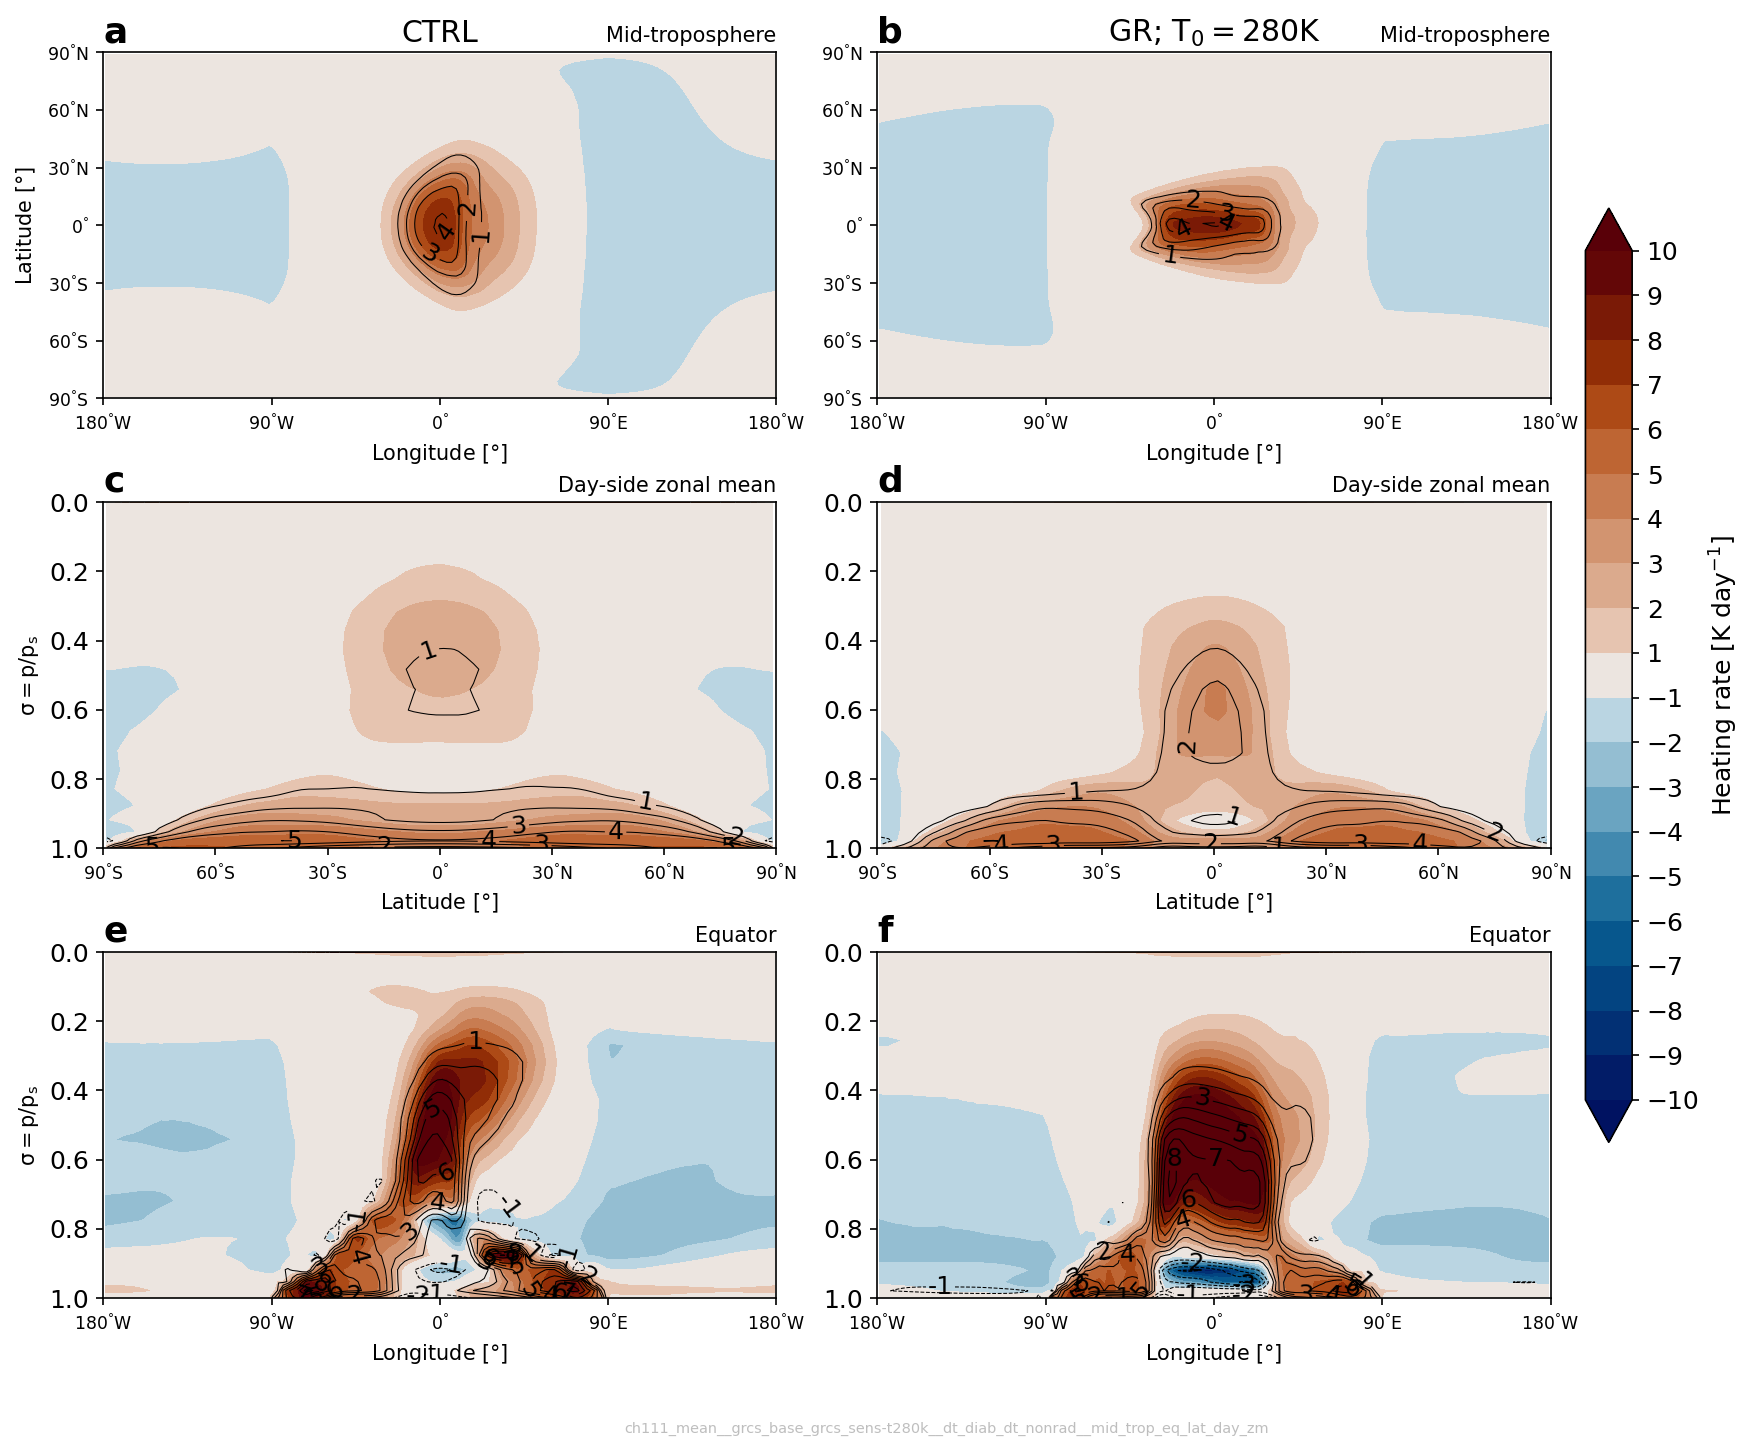

In [27]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__dt_diab_dt_nonrad__mid_trop_eq_lat_day_zm"

ncols = 2
nrows = 3

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 11),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[0, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")
for ax in axs[1, :].flat:
    ax.set_xticks(YLOCS)
    ax.set_xlabel("Latitude [$\degree$]", fontsize="small")
    ax.set_xlim((-90, 90))
    ax.set_xticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
    ax.set_ylim((1, 0))
for ax in axs[2, :].flat:
    ax.set_xticks(XLOCS)
    ax.set_xlabel("Longitude [$\degree$]", fontsize="small")
    ax.set_xlim((-180, 180))
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$\sigma=p/p_s$", fontsize="small")
    ax.set_ylim((1, 0))


for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    ax.set_title("Mid-troposphere", **KW_AUX_TTL)
    _p00 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["dt_diab_mid_trop"].data,
        **KW_HEATING,
    )
    _p01 = ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["dt_nonrad_mid_trop"].data,
        colors="k",
        levels=KW_HEATING["levels"],
        linewidths=0.5,
    )
    ax.clabel(_p01, fmt="%.0f")

    ax = axcol[1]
    ax.set_title("Day-side zonal mean", **KW_AUX_TTL)
    _p10 = ax.contourf(
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["dt_diab_day_zm"].data,
        **KW_HEATING,
    )
    _p11 = ax.contour(
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["dt_nonrad_day_zm"].data,
        colors="k",
        levels=KW_HEATING["levels"],
        linewidths=0.5,
    )
    ax.clabel(_p11, fmt="%.0f")

    ax = axcol[2]
    ax.set_title("Equator", **KW_AUX_TTL)
    _p20 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["dt_diab_eq_lat"].data,
        **KW_HEATING,
    )
    _p21 = ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["sigma_p"].data,
        RESULTS[sim_label]["dt_nonrad_eq_lat"].data,
        colors="k",
        levels=KW_HEATING["levels"],
        linewidths=0.5,
    )
    ax.clabel(_p21, fmt="%.0f")

_cbar0 = fig.colorbar(_p00, ax=axs, **KW_CBAR)
_cbar0.set_ticks(KW_HEATING["levels"])
_cbar0.ax.set_ylabel(f"Heating rate [{tex_units}]", **KW_CBAR_TTL)

figsave(fig, plotdir / imgname)

### Surface temperature, surface winds and clouds

In [28]:
lev_10m = (
    [
        (um.z, [10]),
    ],
    iris.analysis.Linear(),
)

In [29]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points

    RESULTS[sim_label]["t_sfc"] = time_mean(the_run.t_sfc)
    RESULTS[sim_label]["u_10m"] = iris.util.squeeze(
        time_mean(the_run.u).interpolate(*lev_10m)
    )
    RESULTS[sim_label]["v_10m"] = iris.util.squeeze(
        time_mean(the_run.v).interpolate(*lev_10m)
    )

    RESULTS[sim_label]["wvp"] = time_mean(
        water_path(the_run._cubes, kind="water_vapour")
    )
    RESULTS[sim_label]["cwp"] = time_mean(
        water_path(the_run._cubes, kind="cloud_water")
    )

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
KW_WVP = dict(norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap=cm.devon)
KW_CWP = dict(norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0), cmap=cm.oslo)
KW_TSFC = dict(levels=np.arange(180, 291, 10), extend="both", cmap=cm.batlow)

KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

KW_QUIVER_EDDY = dict(
    scale_units="inches",
    scale=50,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__t_sfc_10m_winds_wvp_cwp.png


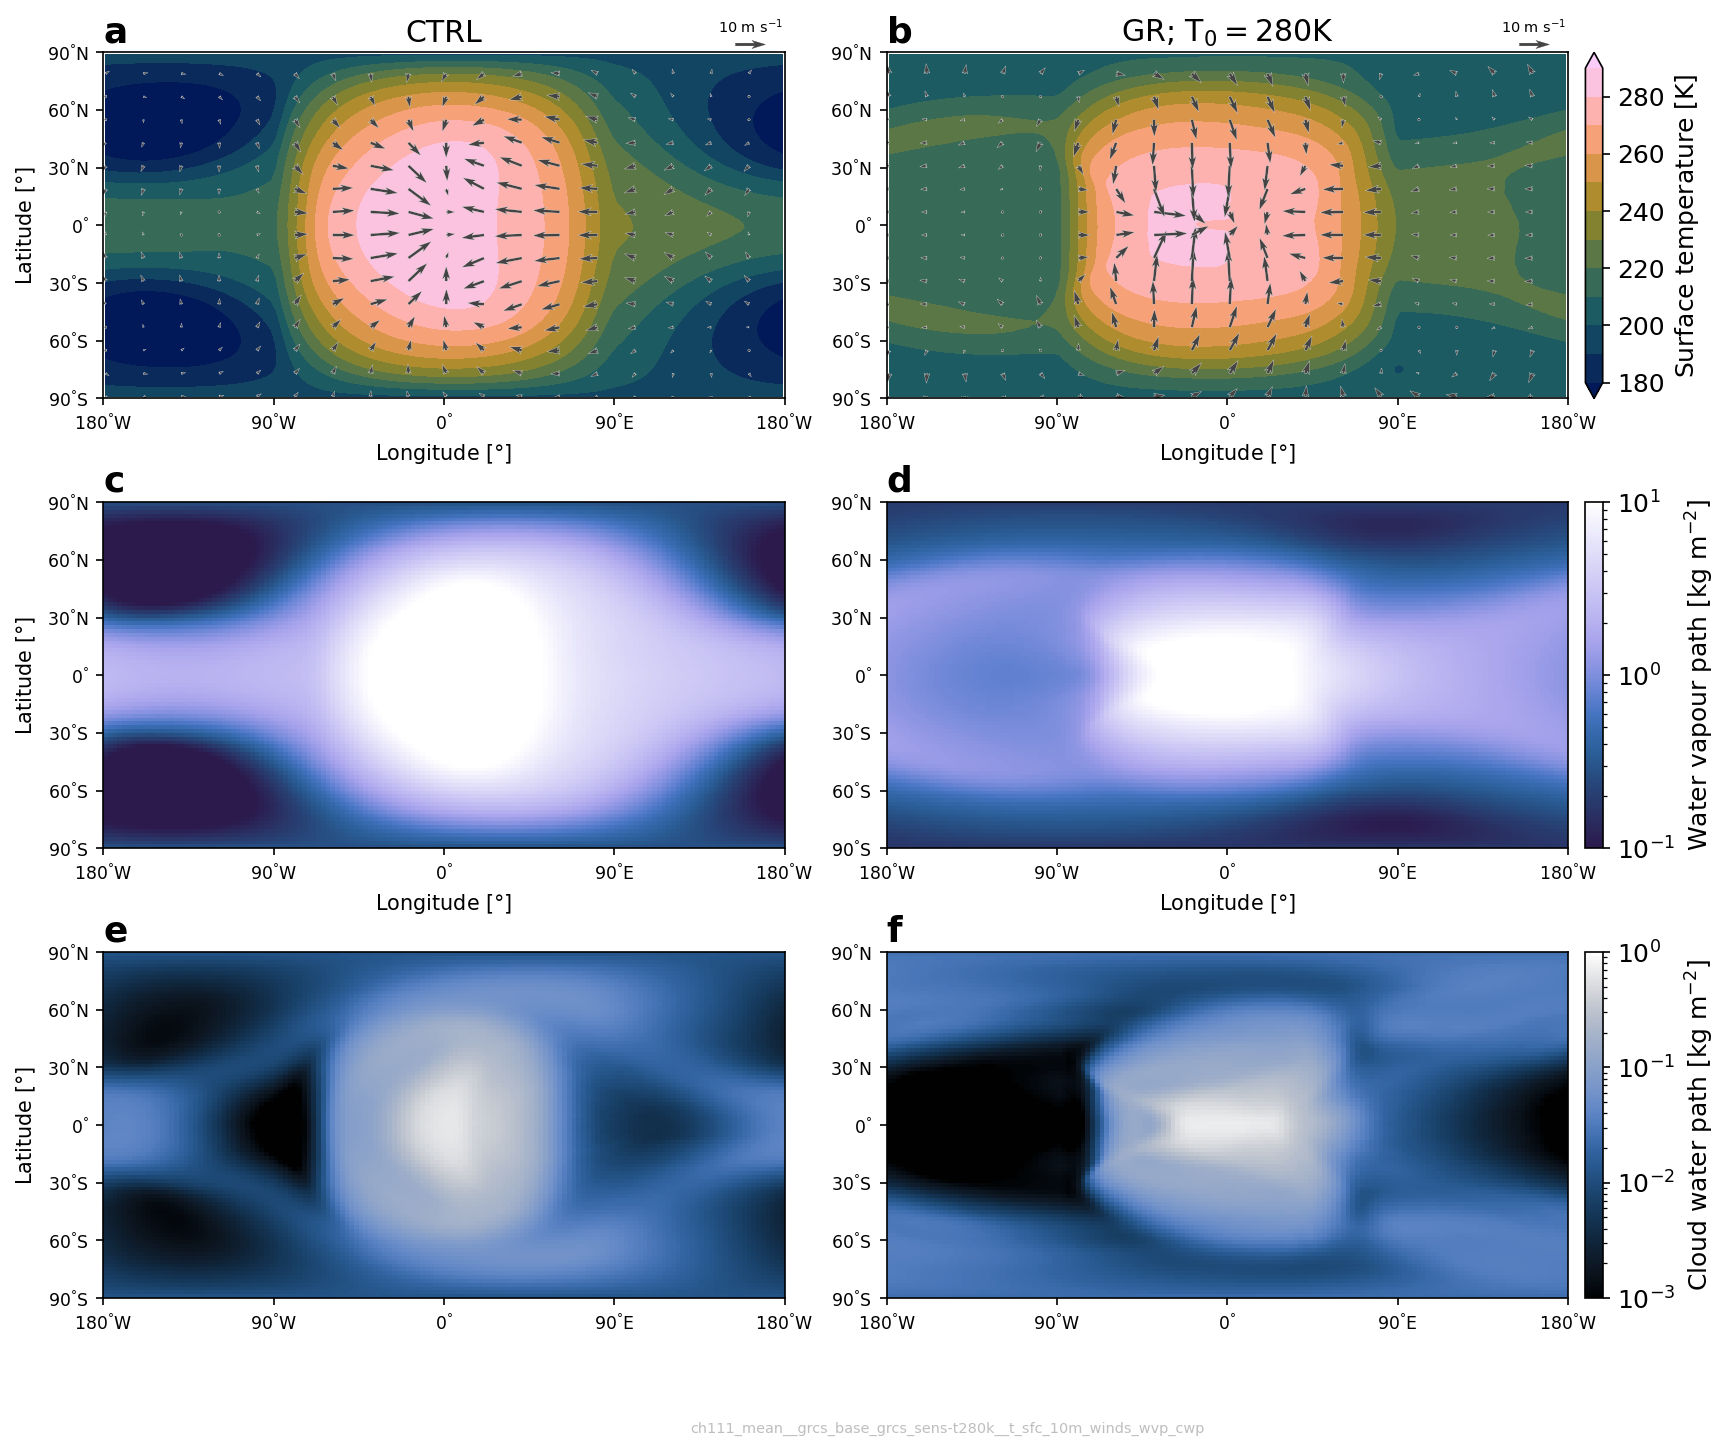

In [31]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__t_sfc_10m_winds_wvp_cwp"

ncols = 2
nrows = 3

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 11),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[:, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    _p0 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["t_sfc"].data,
        **KW_TSFC,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_10m"].data[ysl, xsl],
        RESULTS[sim_label]["v_10m"].data[ysl, xsl],
        **KW_QUIVER_EDDY,
    )
    qk_ref_wspd = 10
    ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )

    ax = axcol[1]
    _p1 = ax.pcolormesh(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["wvp"].data,
        **KW_WVP,
    )

    ax = axcol[2]
    _p2 = ax.pcolormesh(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["cwp"].data,
        **KW_CWP,
    )

_cbar0 = fig.colorbar(_p0, ax=axs[0, :], **KW_CBAR)
_cbar0.ax.set_ylabel("Surface temperature [$K$]", **KW_CBAR_TTL)
_cbar1 = fig.colorbar(_p1, ax=axs[1, :], **KW_CBAR)
_cbar1.ax.set_ylabel("Water vapour path [$kg$ $m^{-2}$]", **KW_CBAR_TTL)
_cbar2 = fig.colorbar(_p2, ax=axs[2, :], **KW_CBAR)
_cbar2.ax.set_ylabel("Cloud water path [$kg$ $m^{-2}$]", **KW_CBAR_TTL)

figsave(fig, plotdir / imgname)

### Geopotential height anomaly vertical cross section

In [78]:
MERIDIONAL_REDUCE = {
    "eq_lat": {"title": "Equator", "func": lambda cube: cube.extract(eq_lat)},
    "midlatitudes": {
        "title": "Mid-latitudes",
        "func": lambda cube: meridional_mean(cube.extract(midlatitudes)),
    },
    "mid_lat": {
        "title": "$51^{\degree}$ latitude",
        "func": lambda cube: meridional_mean(cube.extract(mid_lat)),
    },
}

In [83]:
mer_reduce_label = "midlatitudes"

In [84]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    RESULTS[sim_label] = {}

    # the_run = runs[sim_label]
    the_run_p = runs_p[sim_label]
    RESULTS[sim_label]["lons"] = the_run_p.coord.x.points
    RESULTS[sim_label]["lats"] = the_run_p.coord.y.points
    RESULTS[sim_label]["pres"] = the_run_p.coord.z.points
    # RESULTS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))

    ghgt = MERIDIONAL_REDUCE[mer_reduce_label]["func"](
        (the_run_p.ghgt / the_run_p.const.gravity)
    )
    u = MERIDIONAL_REDUCE[mer_reduce_label]["func"](the_run_p.u)
    w = MERIDIONAL_REDUCE[mer_reduce_label]["func"](the_run_p.w)
    RESULTS[sim_label]["ghgt_dev"] = time_mean(ghgt - zonal_mean(ghgt))
    RESULTS[sim_label]["u_dev"] = time_mean(u - zonal_mean(u))
    RESULTS[sim_label]["w_dev"] = time_mean(w - zonal_mean(w))

  0%|          | 0/2 [00:00<?, ?it/s]

In [85]:
KW_GHGT_DEV = dict(
    cmap=cm.roma_r,
    levels=linspace_pm1(10) * 400,
    extend="both",
)

KW_QUIVER = dict(
    scale_units="inches",
    scale=50,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
zstride = 2
xsl = slice(None, None, xstride)
zsl = slice(None, None, zstride)

Saved to ../plots/ch111_mean/ch111_mean__grcs_base_grcs_sens-t280k__ghgt_dev_midlatitudes.png


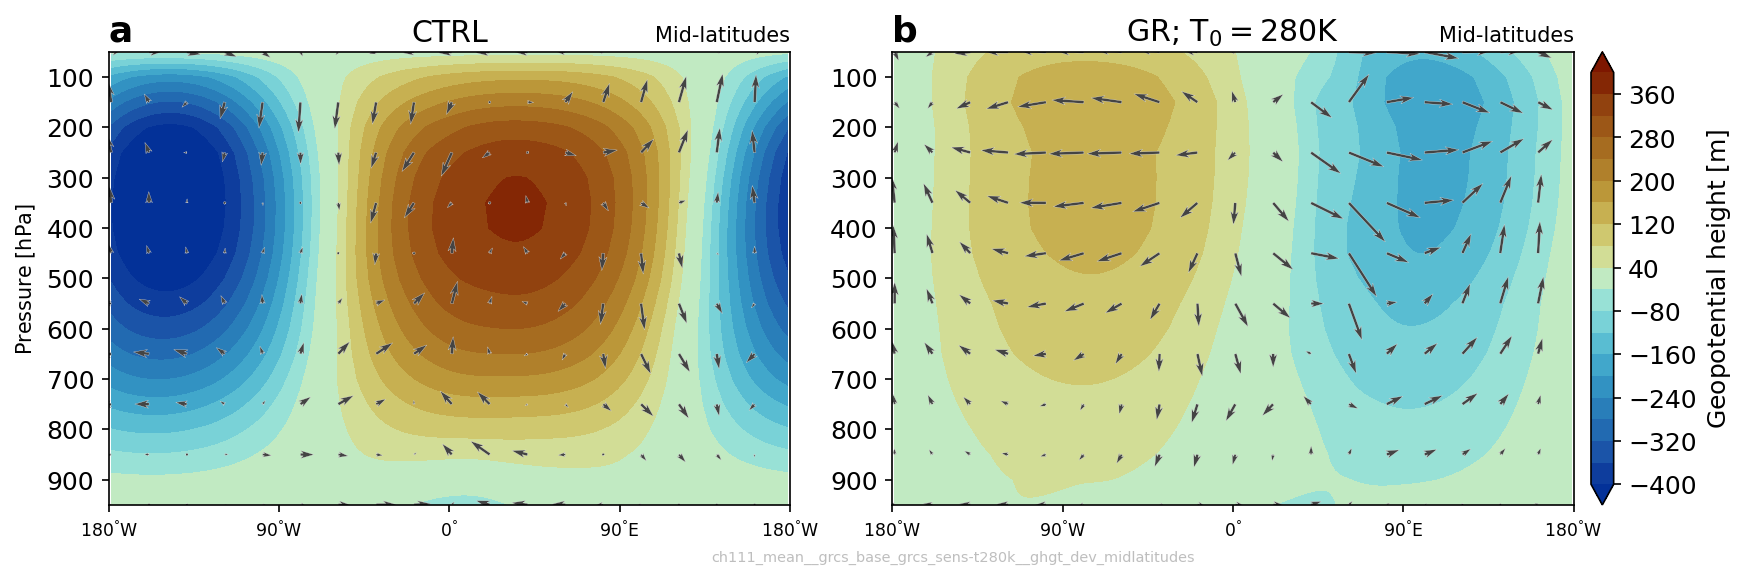

In [87]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__ghgt_dev_{mer_reduce_label}"

ncols = len(SIM_LABELS)
nrows = 1

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 4),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
    squeeze=False,
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(MERIDIONAL_REDUCE[mer_reduce_label]["title"], **KW_AUX_TTL)
for ax in axs.flat:
    ax.set_ylim(950, 50)
    # ax.set_yticks(YLOCS)
    # ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS], fontsize="x-small")
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS], fontsize="x-small")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Pressure [$hPa$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    _p0 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["pres"] * 1e-2,
        RESULTS[sim_label]["ghgt_dev"].data,
        **KW_GHGT_DEV,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["pres"][zsl] * 1e-2,
        RESULTS[sim_label]["u_dev"].data[zsl, xsl],
        RESULTS[sim_label]["w_dev"].data[zsl, xsl] * 1e3,
        **KW_QUIVER,
    )

_cbar0 = fig.colorbar(_p0, ax=axs[0, :], **KW_CBAR)
_cbar0.ax.set_ylabel("Geopotential height [$m$]", **KW_CBAR_TTL)

figsave(fig, plotdir / imgname)

### Momentum flux divergence

In [49]:
sim_label = "grcs_base"
the_run = runs[sim_label]

In [50]:
from zonal_momentum_budget import ZonalMomBudgetFluxForm
ZMB = ZonalMomBudgetFluxForm.from_parent_class(the_run)

In [55]:
YZ_VRBL_PLOT = {
    "mom_flx_div_eddy_stat": {
        "func": lambda AS: time_mean(AS.mom_flx_div_eddy_stat),
        "method": "contourf",
        "kw_plt": dict(cmap=cm.cork, levels=linspace_pm1(8) * 4, extend="both"),
        "tex_units": "$m$ $s^{-1}$ $day^{-1}$",
    },
}

In [56]:
vrbl_key = "mom_flx_div_eddy_stat"
vrbl_opt = YZ_VRBL_PLOT[vrbl_key]

(1.0, 0.0)

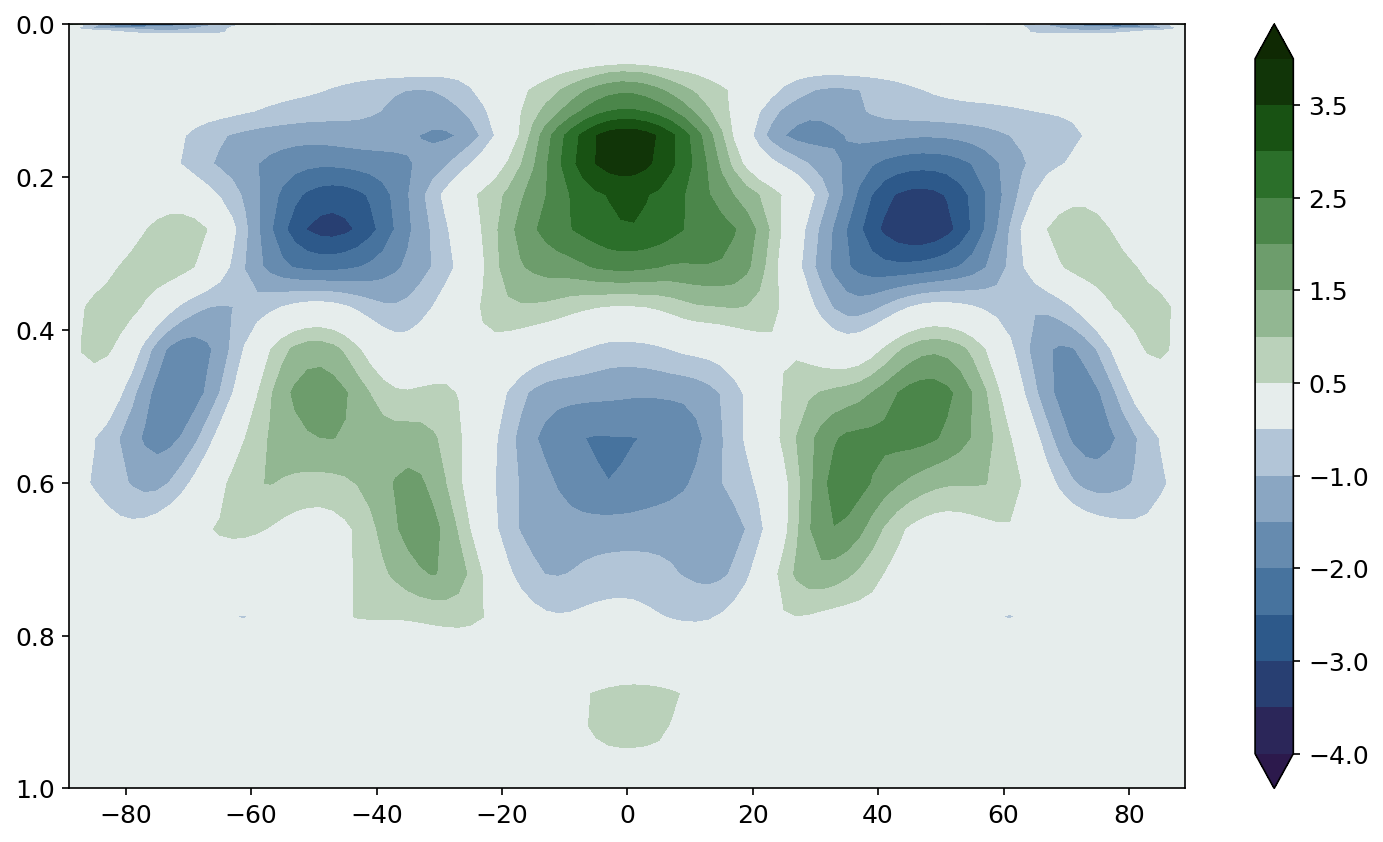

In [59]:
fig, ax = plt.subplots()
cube = vrbl_opt["func"](ZMB)
cube.convert_units(tex2cf_units(vrbl_opt["tex_units"]))
_p0 = getattr(ax, vrbl_opt["method"])(
    ZMB.coord.y.points,
    spatial_mean(time_mean(ZMB.sigma_p)).data,
    cube.data,
    **vrbl_opt["kw_plt"]
)
fig.colorbar(_p0)
ax.set_ylim(1, 0)

### Rossby vs Froude numbers
Following Wang & Mitchell (2014)

$$Ro = \frac{U_0}{2\Omega R_p}$$

$$Fr = \frac{U_0/cos\phi_{max}}{U_{eq}+ NH/m}$$

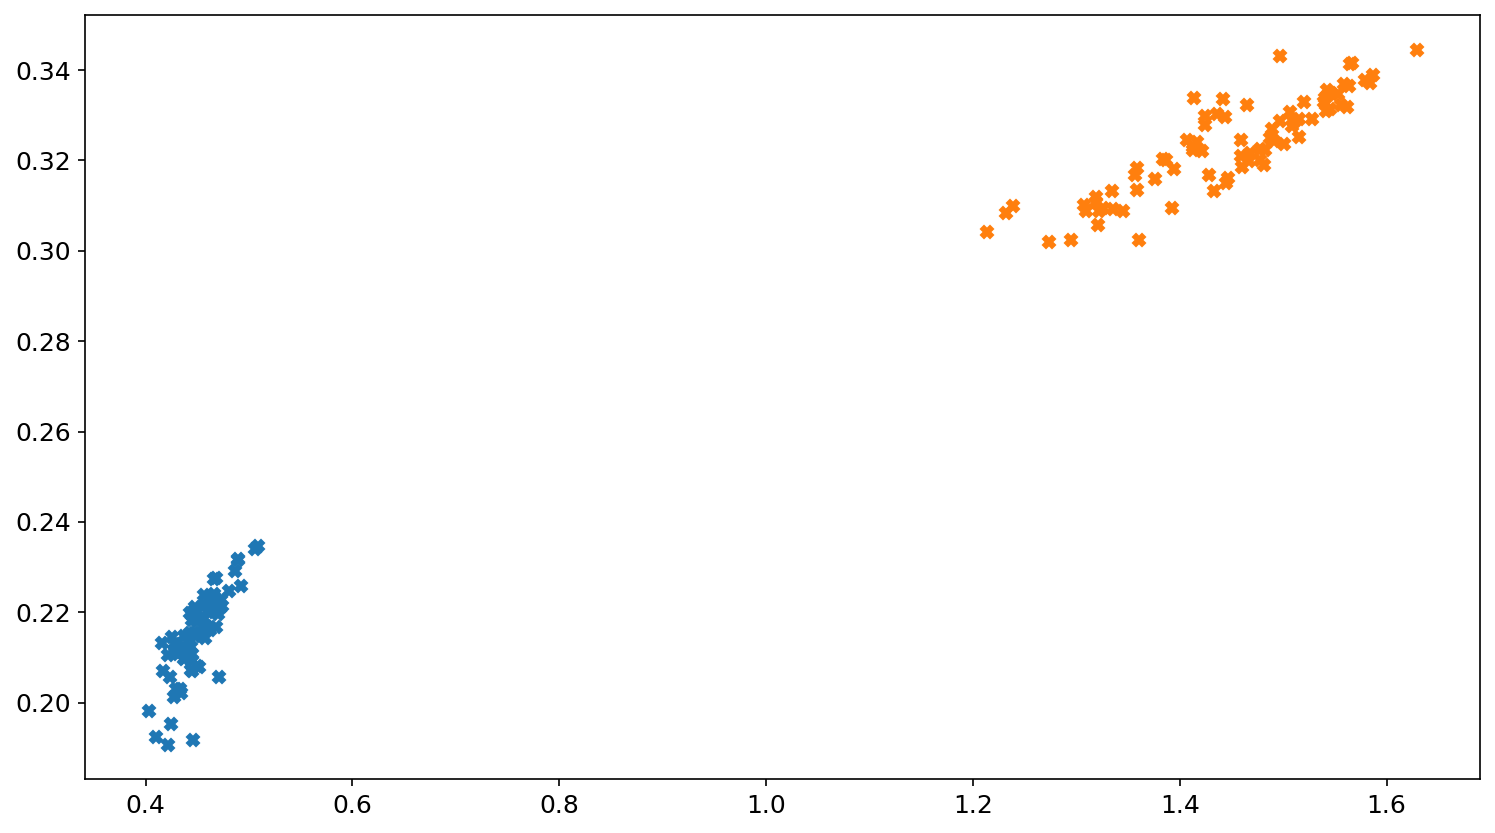

In [143]:
opt_label = "base"
for suite_label in SUITE_LABELS.keys():
    the_run = runs[f"{suite_label}_{opt_label}"]
    the_run_trop = the_run.extract(l_range_constr(0, 17))

    u_0 = spatial(
        zonal_mean(vertical_mean(the_run_trop.u, weight_by=the_run_trop.dens)), "max"
    )
    double_omega_radius = 2 * const.planet_rotation_rate * const.radius
    rossby_number = u_0 / double_omega_radius

    cos_phi_max = apply_ufunc(
        np.cos, apply_ufunc(np.deg2rad, latitude_of_max_zonal_wind(the_run_trop.u))
    )
    cos_phi_max.units = "1"

    u_eq = spatial_mean(
        zonal_mean(vertical_mean(the_run_trop.u, weight_by=the_run_trop.dens)).extract(
            eq_lat
        )
    )

    bv_freq_proxy = (
        spatial(
            vertical_mean(
                bv_freq_sq(the_run_trop._cubes, model=um),
                weight_by=the_run_trop.dens,
                model=um,
            ),
            "mean",
        )
        ** 0.5
    )
    temp_proxy = spatial(
        vertical_mean(the_run_trop.temp, weight_by=the_run_trop.dens, model=um),
        "mean",
    )
    # temp_proxy = spatial_mean(the_run.t_sfc)

    scale_height = (
        the_run.const.dry_air_gas_constant * temp_proxy / the_run.const.gravity
    )
    froude_number = (u_0 / cos_phi_max) / (u_eq + bv_freq_proxy * scale_height / np.pi)

    plt.plot(
        froude_number.data, rossby_number.data, marker="X", lw=0, label=suite_label
    )

### Table with time-mean diagnostics

In [14]:
time_reduce = lambda cube: time_mean(cube, model=um)

In [15]:
P_LEV = 300  # hPa
p_lev_constr = iris.Constraint(**{um.pres: P_LEV * 1e2})

In [16]:
VRBL_PLOT = {
    "dtdz_0_1km": {
        "cube": lambda AS, model=um: spatial(
            mean_dry_lapse_rate(AS._cubes.extract(hgt_cnstr_0_1km), model=model), "mean"
        ),
        "title": "Lapse rate between 0 and 1 km",
        "short_title": r"$dT/dz$",
        "tex_units": "$K$ $km^{-1}$",
        "fmt": lambda x: f"{x:.1f}",
        "lim": [10, 25],
    },
    "up_atm_wv": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes), "mean"),
        "title": "Specific humidity at 100 hPa",
        "short_title": r"$q_{100hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_10hpa": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes, levels=0.01), "mean"),
        "title": "Specific humidity at 10 hPa",
        "short_title": r"$q_{10hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [5e-9, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_term": {
        "cube": lambda AS: spatial(
            upper_atm_vap_mean(
                AS._cubes.extract(iris.Constraint(**{um.x: lambda x: x in [-90, 90]}))
            ),
            "mean",
        ),
        "title": "Specific humidity at 100 hPa\nat the terminators",
        "short_title": r"$q_{100hPa,term}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "b_alb_gm": {
        "cube": lambda AS: spatial(bond_albedo(AS._cubes), "mean"),
        "title": "Bond albedo",
        "short_title": r"$\alpha_b$",
        "tex_units": "1",
        "lim": [0, 0.5],
        "fmt": lambda x: f"{x:.2f}",
    },
    "t_sfc_cold_traps": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
        "title": "Surface temperature in cold traps",
        "short_title": "$T_{s,ct}$",
        "tex_units": "$K$",
        "lim": [160, 260],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_d": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(DAYSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,d}$",
        "tex_units": "$K$",
        "lim": [240, 280],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_n": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(NIGHTSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,n}$",
        "tex_units": "$K$",
        "lim": [195, 235],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_min": {
        "cube": lambda AS: spatial(AS.t_sfc, "min"),
        "title": "Minimum surface temperature",
        "short_title": "$T_{s,min}$",
        "tex_units": "$K$",
        "lim": [165, 220],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_max": {
        "cube": lambda AS: spatial(AS.t_sfc, "max"),
        "title": "Maximum surface temperature",
        "short_title": "$T_{s,max}$",
        "tex_units": "$K$",
        "lim": [280, 310],
        "fmt": lambda x: f"{x:.1f}",
    },
    "jet_lat_free_trop": {
        "cube": lambda AS: latitude_of_max_zonal_wind(AS.u.extract(free_troposphere)),
        "title": "Latitude of the tropospheric jet",
        "short_title": "$\phi_{u_{max}}$",
        "tex_units": "$\degree$",
        "lim": [0, 90],
        "ticks": [0, 30, 60, 90],
        "fmt": lambda x: f"{x:.1f}",
    },
    "ratio_dn_ep_temp_diff_trop": {
        "cube": lambda AS: ratio_of_dn_to_eq_pole_temp_diff(AS.extract(troposphere)),
        "title": "Ratio of the day-night to\nequator-pole temperature difference",
        "short_title": r"$\Delta T_{dn}/\Delta T_{ep}$",
        "tex_units": "1",
        "lim": [0, 1.5],
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_mean_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "mean"),
        "title": f"Mean zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$\overline{u_{eq}}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [15, 55],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_max_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
        "title": f"Maximum zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$u_{eq,max}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [0, 100],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    "dtemp_dphi_tropmean": {
        "cube": lambda AS: spatial(
            -1
            * abs_coord_mean(
                zonal_mean(
                    d_dphi(
                        vertical_mean(
                            AS.temp.extract(troposphere),
                            weight_by=AS.dens.extract(troposphere),
                        )
                    )
                ),
                um.y,
            ),
            "max",
        ),
        "title": "Meridional gradient\nof the mean tropospheric\ntemperature",
        "short_title": r"$\overline{\Delta T_{ep}}$",
        "tex_units": "$K$ $(1000 km)^{-1}$",
        "lim": [0, 10],
        "ax": 0,
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_lh_dayside_eq": {
        "cube": lambda AS: time_reduce(
            spatial_mean(
                vertical_mean(
                    latent_heating_rate(AS._cubes), weight_by=AS.dens
                ).extract(DAYSIDE.constraint & eq_lat)
            )
        ),
        "tex_units": "$K$ $day^{-1}$",
        "title": "Dayside latent heating",
        "short_title": r"$(\partial T/\partial t)_{lh}$",
        "lim": [0, 6],
        "fmt": lambda x: f"{x:.1f}",
    },
}

In [ ]:
RESULTS = {}
for vrbl_key, vrbl_prop in tqdm(VRBL_PLOT.items()):
    RESULTS[vrbl_key] = {}
    for suite_label, suite_prop in tqdm(SUITE_LABELS.items(), leave=False):
        for opt_label in tqdm(OPT_LABELS.keys(), leave=False):
            if opt_label != "base":
                ...
                # continue
            sim_label = f"{suite_label}_{opt_label}"
            if vrbl_prop.get("source", "") == "p":
                the_run = runs_p[sim_label]
            else:
                the_run = runs[sim_label]

            # Calculate diagnostics
            cube = time_reduce(vrbl_prop["cube"](the_run))
            try:
                cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
            except ValueError:
                pass
            RESULTS[vrbl_key][sim_label] = cube

In [18]:
dfs = {}
for suite_label, suite_prop in SUITE_LABELS.items():
    for opt_label, opt_prop in OPT_LABELS.items():
        if opt_label != "base":
            ...
            # continue
        sim_label = f"{suite_label}_{opt_label}"
        _data = {}
        for vrbl_key, vrbl_prop in VRBL_PLOT.items():
            _data[vrbl_prop["short_title"]] = float(RESULTS[vrbl_key][sim_label].data)
        dfs[sim_label] = pd.DataFrame(
            _data,
            index=pd.Index(
                name="Experiment", data=[f"{suite_prop['title']}; {opt_prop['title']}"]
            ),
        )

In [ ]:
df = pd.concat(dfs, axis="index").droplevel(0)

formatters = {
    k: {j["short_title"]: j["fmt"] for j in VRBL_PLOT.values()}[k] for k in df.columns
}

# df.columns = [fr"\colhead{{{i}}}" for i in df.columns]
print(
    df.to_latex(
        formatters=formatters,
        column_format="l" + "c" * len(VRBL_PLOT),
        escape=False,
    )
)

In [26]:
KW_PLT_GROUPS = {
    "base": {"title": "Base", "kw_plt": dict(marker="o")},
    "sens-noradcld": {"title": "No CRE", "kw_plt": dict(marker="D")},
    "sens-fixedsst": {"title": "Fixed $T_{s}$", "kw_plt": dict(marker="*")},
    "sens-hcapsea": {"title": "Slab ocean depth", "kw_plt": dict(marker="s")},
    "sens-t": {"title": "Initial temperature $T_{0}$", "kw_plt": dict(marker="X")},
}

In [27]:
VRBL_PLOT.keys()

dict_keys(['dtdz_0_1km', 'up_atm_wv', 'up_atm_wv_10hpa', 'up_atm_wv_term', 'b_alb_gm', 't_sfc_cold_traps', 't_sfc_d', 't_sfc_n', 't_sfc_min', 't_sfc_max', 'jet_lat_free_trop', 'ratio_dn_ep_temp_diff_trop', 'u_mean_eq_jet_300hpa', 'u_max_eq_jet_300hpa', 'dtemp_dphi_tropmean', 'dt_lh_dayside_eq'])

In [29]:
vrbl_key_x = "u_mean_eq_jet_300hpa"
vrbl_key_y = "t_sfc_cold_traps"

In [ ]:
# for vrbl_key_x, vrbl_key_y in tqdm(itertools.combinations(VRBL_PLOT.keys(), 2)):
# {'_'.join([i.replace('sens-','') for i in OPT_LABELS.keys()])}
imgname = f"{img_prefix}__all_sim__{vrbl_key_x}_{vrbl_key_y}"
kw_plt_common = {"linewidth": 0, "ms": 10, "mec": "tab:grey"}
fig, ax = plt.subplots()

xlabel = VRBL_PLOT[vrbl_key_x]["title"]
if VRBL_PLOT[vrbl_key_x]["tex_units"] != "1":
    xlabel += f' [{VRBL_PLOT[vrbl_key_x]["tex_units"]}]'
ylabel = VRBL_PLOT[vrbl_key_y]["title"]
if VRBL_PLOT[vrbl_key_y]["tex_units"] != "1":
    ylabel += f' [{VRBL_PLOT[vrbl_key_y]["tex_units"]}]'

ax.set(
    xlim=VRBL_PLOT[vrbl_key_x].get("lim"),
    xlabel=xlabel,
    xscale=VRBL_PLOT[vrbl_key_x].get("scale", "linear"),
    ylim=VRBL_PLOT[vrbl_key_y].get("lim"),
    ylabel=ylabel,
    yscale=VRBL_PLOT[vrbl_key_y].get("scale", "linear"),
)

texts = []
for suite_label, suite_prop in SUITE_LABELS.items():
    for opt_label, opt_prop in OPT_LABELS.items():
        sim_label = f"{suite_label}_{opt_label}"
        kw_plt = [
            v for k, v in KW_PLT_GROUPS.items() if opt_label.lower().startswith(k)
        ][0]["kw_plt"]
        ax.plot(
            RESULTS[vrbl_key_x][sim_label].data,
            RESULTS[vrbl_key_y][sim_label].data,
            **kw_plt_common,
            **suite_prop["kw_plt"],
            **kw_plt,
        )
        texts.append(
            ax.text(
                RESULTS[vrbl_key_x][sim_label].data,
                RESULTS[vrbl_key_y][sim_label].data,
                opt_prop["title"],
                color=suite_prop["kw_plt"]["color"],
            )
        )
add_custom_legend(
    ax,
    {
        group_prop["title"]: {
            "color": "tab:grey",
            **kw_plt_common,
            **group_prop["kw_plt"],
        }
        for _, group_prop in KW_PLT_GROUPS.items()
    },
    loc="upper left",
    bbox_to_anchor=(1.0, 1.0),
    frameon=False,
    ncol=1,
    title="Groups of sensitivity experiments",
    handletextpad=-0.2,
)
add_custom_legend(
    ax,
    {
        suite_prop["title"]: {
            "marker": "o",
            **kw_plt_common,
            **suite_prop["kw_plt"],
        }
        for _, suite_prop in SUITE_LABELS.items()
    },
    loc="lower left",
    bbox_to_anchor=(1.0, 0.0),
    frameon=False,
    ncol=1,
    title="Cases",
    handletextpad=-0.2,
)
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color="tab:grey", alpha=0.5))
figsave(fig, plotdir / imgname)

### Maps of surface temperature in the sens-fixedsst experiment

In [47]:
chosen_opt_labels = ["sens-fixedsst", "sens-fixedsst-day-night"]

216.12091064453125 293.79986572265625
189.56198120117188 287.4574279785156
170.6182403564453 287.4574279785156
170.6182403564453 293.79986572265625
Saved to ../../plots/sa/ch111/ch111_mean/ch111_mean__grcs_llcs__sens-fixedsst_sens-fixedsst-day-night__t_sfc_300hpa_winds.png


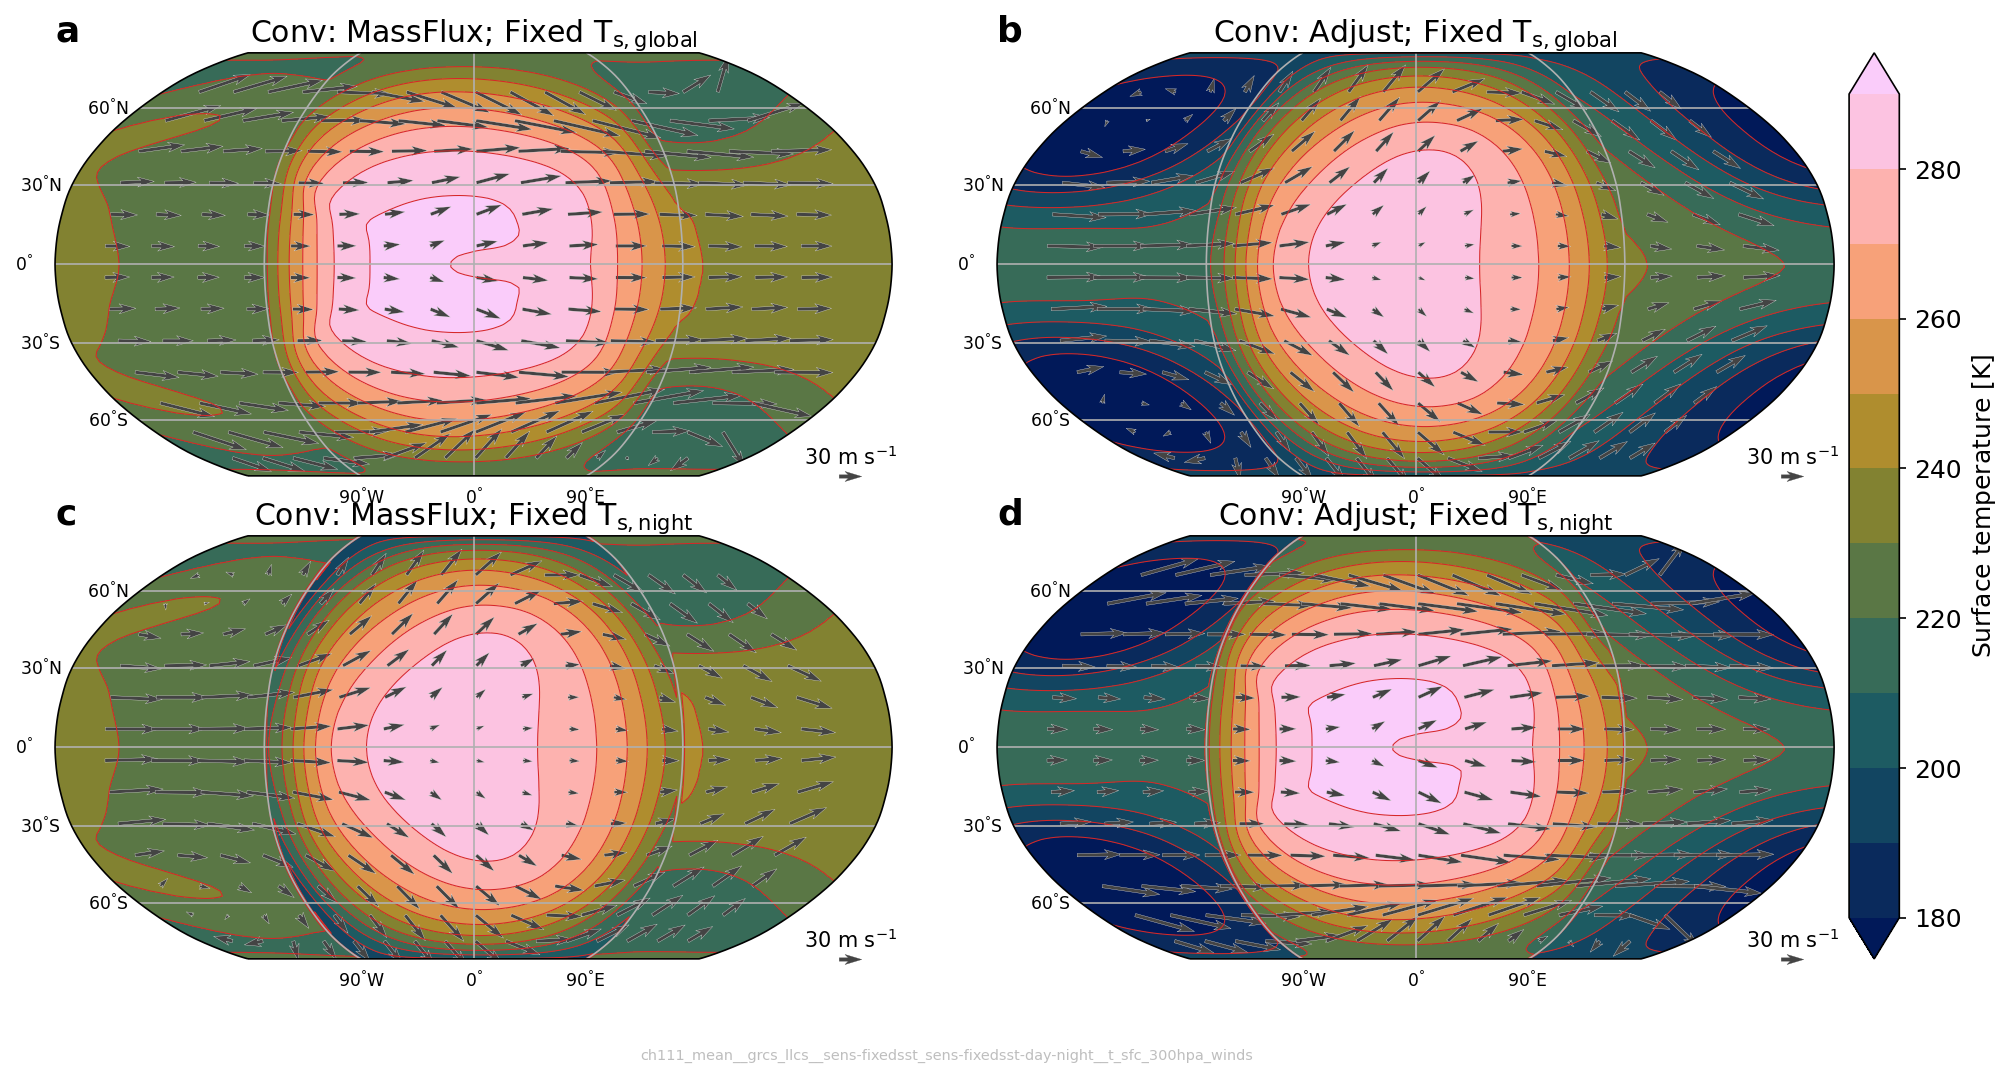

In [62]:
imgname = f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__{'_'.join(chosen_opt_labels)}__t_sfc_{P_LEV1}hpa_winds"

fig, axgr = make_map_figure(2, 2, **KW_AXGR)
cax = axgr.cbar_axes[0]
axs = np.array(axgr.axes_column)

iletters = subplot_label_generator()
for ax in axs.T.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)

for (suite_label, suite_prop), axcol in zip(SUITE_LABELS.items(), axs):
    for opt_label, ax in zip(chosen_opt_labels, axcol):
        ax.set_title(
            f'{suite_prop["title"]}; {OPT_LABELS[opt_label]["title"]}', **KW_MAIN_TTL
        )
        sim_label = f"{suite_label}_{opt_label}"
        the_run = runs[sim_label]
        the_run_p = runs_p[sim_label]

        t_sfc_map = time_mean(the_run.t_sfc)
        print(t_sfc_map.data.min(), t_sfc_map.data.max())
        u_map = time_mean(the_run_p.u.extract(p_lev_constr1))
        v_map = time_mean(the_run_p.v.extract(p_lev_constr1))

        p0 = draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contourf",
            cmap=cm.batlow,
            cax=cax,
            levels=np.arange(180, 291, 10),
            extend="both",
        )
        draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contour",
            colors="tab:red",
            levels=np.arange(180, 291, 10),
            linewidths=0.5,
        )
        draw_vector_cubes(
            u_map,
            v_map,
            ax,
            xstride=8,
            ystride=6,
            qk_ref_wspd=30,
            kw_quiver={**KW_QUIVER, **KW_CART},
            kw_quiverkey=KW_QUIVERKEY,
            quiverkey_xy=(0.95, 0.00),
        )


cax.set_ylabel("Surface temperature [$K$]", **KW_CBAR_TTL)
figsave(fig, plotdir / imgname)

### Sigma-pressure

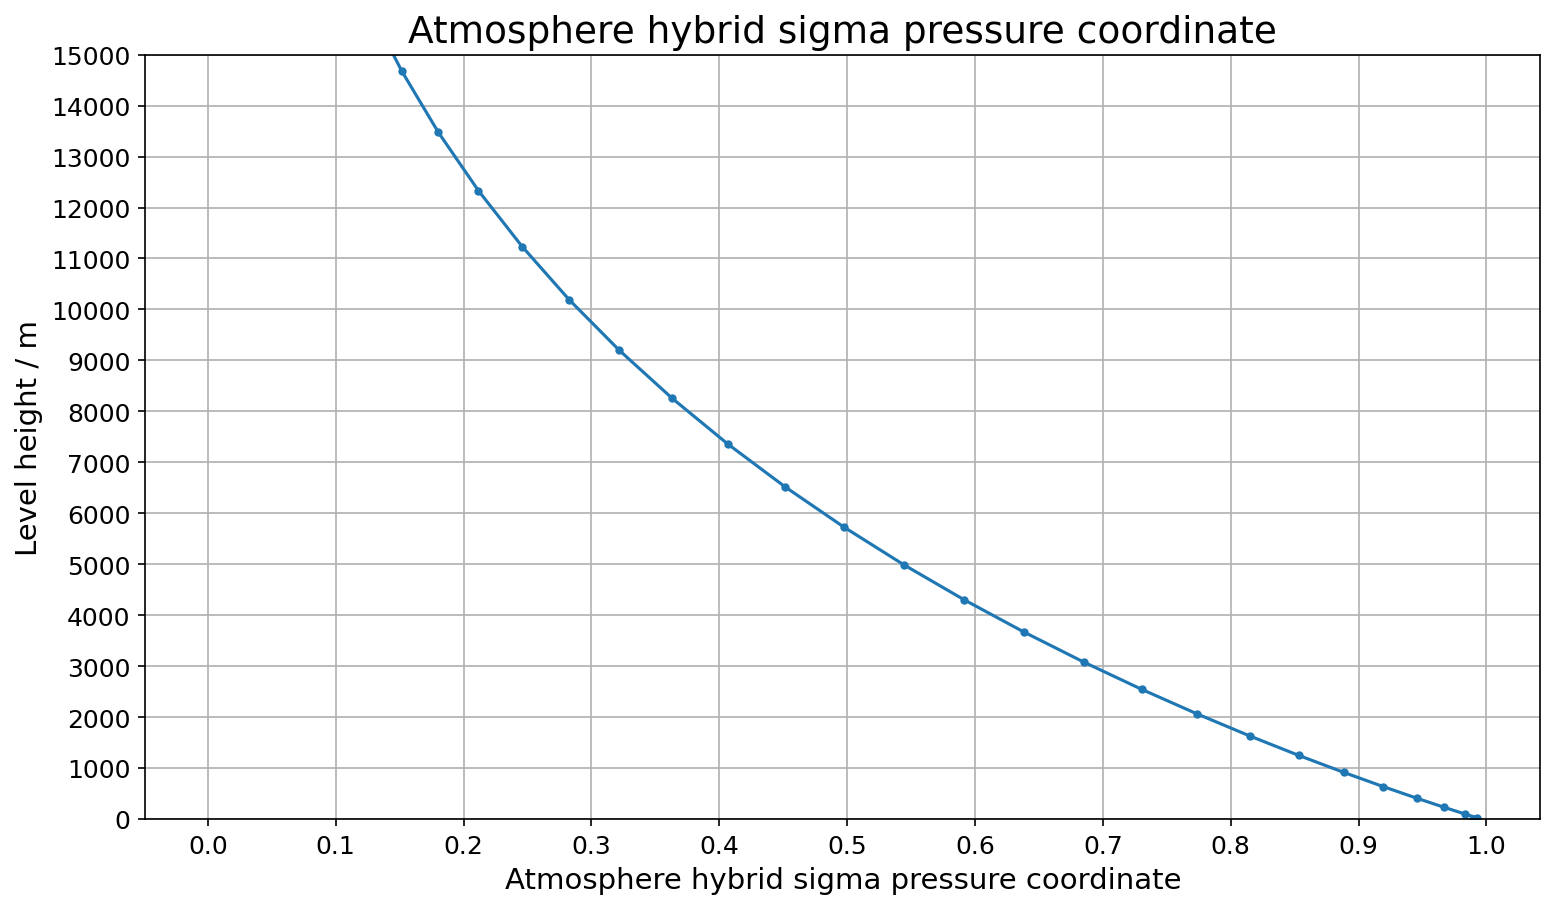

In [94]:
qplt.plot(the_run.sigma_p, the_run.coord.z, marker=".")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 16e3, 1e3))
plt.ylim(0, 15e3)
plt.grid()